# Replication code

Load packages

In [3]:
# Python packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.signal import detrend
import statsmodels.api as sm
import pandas as pd
import time
np.seterr(divide='ignore', invalid='ignore')

# Options for figures
import seaborn as sns
greenslide='#008C00'
redslide='#A00000'
blueslide='#0000A0'
cpalette=sns.color_palette("cubehelix", 5)
plt.rcParams['axes.xmargin'] = 0
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{mathpazo}')
plt.rc('font', family = 'serif')
plt.rc('font', size=10)

# Sequence Jacobian packages - to install, use "pip install sequence-jacobian"
import sequence_jacobian as sj
from sequence_jacobian.utilities import discretize, interpolate, optimized_routines
import aux_fn
import aux_model as mod
from sequence_jacobian.blocks.auxiliary_blocks import jacobiandict_block
from sequence_jacobian.classes import FactoredJacobianDict

Choose whether to calibrate model

In [5]:
calib = False

## Define models

In [9]:
# Simple model (section 2,3,4)
exogenous=['r','rstar','rpost_shock']
unknowns=['y']
targets=['goods_clearing']
blocks = [mod.hh_HA, mod.hh_outputs, mod.foreign_c, mod.rsimple, mod.income, mod.revaluation, mod.profitcenters, mod.UIP, mod.assets_market, mod.goods_market, mod.CA, mod.unions]
mod_simple = sj.create_model(blocks, name="Simple Model")

# Quantitative model (section 5)
exogenous_quant=['ishock','rstar','Z']
unknowns_quant=['y','pi','w','r']
targets_quant=['goods_clearing','pires','real_wage','fisher']
blocks_quant = [mod.hh_HA, mod.hh_outputs_ds, mod.foreign_c_ds, mod.xrule, mod.xrule_foreign, mod.rsimple, mod.income_quant, mod.longbonds, mod.revaluation_quant, mod.profitcenters_quant, mod.UIP_quant, mod.assets_market, mod.goods_market, mod.CA_quant, mod.unions, mod.pi_to_P, mod.nkpc, mod.nkpc_X, mod.nkpc_I, mod.cpi, mod.prices, mod.eq_quant, mod.taylor, mod.fiscal]
mod_quant = sj.create_model(blocks_quant, name="Quantitative Model")

# Model with E shocks (for calibration)
blocks_Erule = [mod.hh_HA, mod.hh_outputs_ds, mod.foreign_c_ds, mod.xrule, mod.xrule_foreign, mod.rsimple, mod.income_quant, mod.longbonds, mod.revaluation_quant, mod.profitcenters_quant, mod.assets_market, mod.goods_market, mod.CA_quant, mod.unions, mod.pi_to_P, mod.nkpc, mod.nkpc_X, mod.nkpc_I, mod.cpi, mod.prices, mod.eq_quant, mod.fiscal, mod.piE_to_E, mod.monetary_Erule, mod.UIP_Erule]
mod_Erule = sj.create_model(blocks_Erule, name="Model with fixed nominal exchange rate")

# Delayed substitution block (for calibration)
blocks_delayedsub = sj.create_model([mod.hh_outputs_ds,mod.foreign_c_ds, mod.xrule_foreign, mod.xrule], name="Delayed substitution blocks")

# Quantitative model with endogenous UIP deviation (for appendix)
exogenous_uip = ['ishock','rstar_exo','Z']
unknowns_uip = ['y','pi','w','r','rstar']
targets_uip = ['goods_clearing','pires','real_wage','fisher','rstar_res']
blocks_uip = [mod.rstar_eq, mod.hh_HA, mod.hh_outputs_ds, mod.foreign_c_ds, mod.xrule, mod.xrule_foreign, mod.rsimple, mod.income_quant, mod.longbonds, mod.revaluation_quant, mod.profitcenters_quant, mod.UIP_quant, mod.assets_market, mod.goods_market, mod.CA_quant, mod.unions, mod.pi_to_P, mod.nkpc, mod.nkpc_X, mod.nkpc_I, mod.cpi, mod.prices, mod.eq_quant, mod.taylor, mod.fiscal]
mod_uip = sj.create_model(blocks_uip, name="Model with endogenous UIP")

# Quantitative RA model (for appendix)
blocks_quant_ra = [mod.hh_RA, mod.hh_outputs_ds, mod.foreign_c_ds, mod.xrule, mod.xrule_foreign, mod.rsimple, mod.income_quant, mod.longbonds, mod.revaluation_quant, mod.profitcenters_quant, mod.UIP_quant, mod.assets_market, mod.goods_market, mod.CA_quant, mod.unions, mod.pi_to_P, mod.nkpc, mod.nkpc_X, mod.nkpc_I, mod.cpi, mod.prices, mod.eq_quant, mod.taylor, mod.fiscal]
mod_quant_ra = sj.create_model(blocks_quant_ra, name="Quantitative RA Model")

## Steady state

In [12]:
def calibrate_ss(calib = '', calib_list = [], eta = 1, gamma=1, eis = 1, alpha = 0.4, alphastar=0.4, markup_ss= 1.031, r=0.01, 
                 sigma_e = 0.8830957229473172, rho_e = 0.9118856622848671, nE = 7, 
                 cbarF = 0, zeta_e = 0, 
                 eps_dcp = 1, pcX_home = 1, theta_X = 1e-6, 
                 theta_share = 1e-6, theta_w = 0.938, theta_p = 1e-6, theta_I = 1e-6, 
                 realrate = 1, phi_piHH = 0, phi_pi = 0, phi_pinext = 1, phi_i = 0,
                 f_FY = 0, BbarY = 0, rho_B = 0.8, lbda = 1, D = 18, foreign_owned = 0,
                 beta_min=0.90, beta_max=0.99, amin = 0, verbose=True):
    
    # Structural parameters
    ss = {'r': r,                         # real interest rate
          'eis': eis,                     # EIS
          'gamma': gamma,                 # Elasticity of foreign demand
          'eta': eta,                     # Elasticity of substitution between goods
          'alpha': alpha,                 # Home bias - consumption share on foreign good
          'alphastar': alphastar,         # Home bias abroad - consumption share on foreign good
          'frisch': 1/2,                  # labor supply elasticity
          'cbarF': cbarF,                 # substistance level on foreign good (necessity)
          'zeta_e': zeta_e,               # degree of gamma heterogeneity
          'phi_piHH': phi_piHH,           # Taylor rule parameter on PPI
          'phi_pi': phi_pi,               # Taylor rule parameter on CPI
          'phi_pinext': phi_pinext,       # Taylor rule parameter on future CPI
          'phi_i': phi_i,                 # Taylor rule parameter for inertia
          'realrate': realrate,           # Real rate rule or Taylor rule
          'markup_ss': markup_ss,         # Firms markup
          'theta_w': theta_w,             # Calvo parameter for wages
          'theta_p': theta_p,             # Calvo parameter for prices
          'theta_I': theta_I,             # Calvo parameter for imports
          'theta_X': theta_X,             # Calvo parameter for exports
          'theta_share': theta_share,     # Calvo parameter for consumption shares
          'lamba': eta/(1-alpha),         # Other parameter for consumption shares
          'lamba_F': gamma/alphastar,     # Other parameter for consumption shares
          'nfa': 0,                       # steady state nfa
          'f_FY': f_FY,                   # real assets invested in foreign assets as a share of quarterly gdp
          'foreign_owned': foreign_owned, # are firms owned by foreigners?
          'BbarY': BbarY,                 # Gross government debt held in foreign assets as a share of quarterly gdp
          'rho_B': rho_B,                 # AR(1) coefficient on public debt
          'lbda': lbda,                   # Progressivity of taxation: 1 is lump-sum; 0 is proportional to labor income
          'eps_dcp':eps_dcp,              # degree of pcp-dcp (1 if pcp; 0 if dcp)
          'pcX_home':pcX_home}            # Home profit center or not

    # Select calibration
    if calib != '':
        for vv in ['markup_ss','cbarF','alpha','zeta_e']:
            ss[vv] = calib_list[calib][vv]

    # Rescale standard deviation of income for non-homothetic model to make sure that everyone can afford the subsistance level and the cross-sectional deviation of income is the same
    ss.update({'nA' : 150, 'sigma_e': sigma_e, 'rho_e': rho_e, 'amin': amin, 'amax': 4*100, 'nE': nE})
    e, pi, _ = discretize.markov_rouwenhorst(rho=rho_e, sigma=sigma_e, N=nE)                                  # note: here sigma_e is the standard deviation of logs (not of the innovation)
    sigma_ref = np.sqrt(pi@(e**2)-(pi@e)**2)
    def res(sigma):
        e, pi, _ = discretize.markov_rouwenhorst(rho=rho_e, sigma=sigma, N=nE)
        e = e*(1-ss['markup_ss']*ss['cbarF']) + ss['markup_ss']*ss['cbarF']
        return sigma_ref - np.sqrt(pi@(e**2)-(pi@e)**2)
    sigma_e_rescaled = opt.brentq(res, 0.1, 1.5, xtol=1e-12, rtol = 1e-12)

    # Computational parameters
    ss['a_grid'] = discretize.agrid(amax=ss['amax'], n=ss['nA'], amin=ss['amin'])
    ss['e_grid'], ss['pi_e'], ss['Pi'] = discretize.markov_rouwenhorst(rho=ss['rho_e'], sigma=sigma_e_rescaled, N=ss['nE'])
    ss['e_grid'] = ss['e_grid']*(1-ss['markup_ss']*ss['cbarF']) + ss['markup_ss']*ss['cbarF']               # adjust grids for non-homotheticity
    ss.update({'beta_min': beta_min, 'beta_max': beta_max})
    ss['n_beta'] = 1
    ss['n_exog'] = ss['n_beta'] * nE

    # Normalizations
    ss.update({'Q': 1, 'Z': 1, 'y': 1, 'rpost_shock': 0, 'ishock': 0, 'Transfer': 0, 'piw': 0, 'P': 1, 'B': 0})
    ss['M'] = ss['n_beta']*np.tile(ss['e_grid']**(1-ss['lbda'])/((ss['e_grid']**(1-ss['lbda']))@ss['pi_e']),(ss['nA'],1)).T

    # From UIP
    ss.update({'rstar': ss['r'], 'rstar_out': ss['r'], 'phh': 1, 'phf': 1, 'pfh': 1, 'dividend_X': 0})

    # Solve steady state
    blocks_ss = [mod.hh_HA, mod.hh_outputs, mod.rsimple, mod.income, mod.revaluation, mod.assets_market]
    unknowns_ss = {'beta': (beta_min,beta_max)}
    targets_ss= ['assets_clearing']
    mod_ss = sj.create_model(blocks_ss, name="SS Model")
    ss = mod_ss.solve_steady_state(ss, unknowns_ss, targets_ss)
    ss['a'], ss['c'], ss['coh'] = ss.internals['hh_HA']['a'], ss.internals['hh_HA']['c'], ss.internals['hh_HA']['coh']
    
    # Delayed substitution
    ss['x'] = 1-ss['alpha']
    ss['xstar'] = ss['x']
    ss['x_F'] = ss['alphastar']
    ss['xstar_F'] = ss['x_F']
    ss['beta_star'] = 1/(1+ss['r'])

    # Consumption statistics
    ss['mpc'] = aux_fn.mpcs(ss['c'], ss['a'], ss['a_grid'], ss['coh'])
    ss['cHi'] = (1-ss['alpha'])*ss['c']
    ss['cFi'] = ss['cbarF'] + ss['alpha']*ss['c']
    ss['share_F'] = ss['cFi']/(ss['cFi']+ss['cHi'])
    ss['cHstar'] = (ss['y']-ss['cH'])
    ss['Cstar'] = ss['cHstar']/ss['alphastar']
    ss['CT'] = ss['cH'] + ss['cF']
    ss['chi'] = (1-ss['alpha'])*ss['eta'] + ss['gamma']*ss['eps_dcp']
    ss['netexports'] = ss['y'] - ss['cF'] - ss['cH'] 
    ss['w'] = 1/ss['markup_ss']
    ss['Css'] = ss['CT']
    ss['div_tot'] = ss['dividend']

    # Nominal variables
    ss.update({'pi':ss['piw'], 'piHH':ss['piw'], 'PHH':1, 'piHF':ss['piw'], 'PHF':1, 'piFH':ss['piw'], 'PFH':1, 'piout': ss['piw'], 'piw_target': ss['piw']})
    ss['kappa_w'] = (1-ss['theta_w'])*(1-ss['beta']*ss['theta_w'])/ss['theta_w']
    ss['kappa_p'] = (1-ss['theta_p'])*(1-ss['beta']*ss['theta_p'])/ss['theta_p']
    ss['kappa_I'] = (1-ss['theta_I'])*(1-ss['beta']*ss['theta_I'])/ss['theta_I']
    ss['kappa_X'] = (1-ss['theta_X'])*(1-ss['beta']*ss['theta_X'])/ss['theta_X']
    ss['vphi'] = ss['atw'] * 1/ss['markup_ss'] * ss['CT']**(-1/ss['eis']) * ss['n']**(-1/ss['frisch'])
    ss['E'] = ss['Q']*ss['P']
    ss['i'] = ss['r'] + ss['pi']
    ss['rss'] = ss['r']
    ss['ires'] = 0
   
    # Compute incidence for calibration of gamma heterogeneity
    ss['incidence_i'] = np.tile(1+ss['zeta_e']*np.log(ss['e_grid'])-ss['zeta_e']*np.sum(ss['pi_e']*np.log(ss['e_grid'])*ss['e_grid']),(ss['nA'],1)).T
    
    # Balance sheet effects
    ss['rpost_F'] = ss['r']
    ss['rpost_H'] = ss['r']
    ss['f_firm'] = ss['j']/ss['A']
    ss['a_F'] = ss['f_FY']*ss['y']
    ss['a_H'] = ss['nfa']-ss['a_F']
    ss['f_F'] = ss['a_F']/ss['A']
    ss['Bbar'] = ss['BbarY']*ss['y']
    ss['delta'] = (1+ss['rstar'])*(1-1/D)
    ss['q'] = 1/(1 + ss['rstar'] - ss['delta'])
    ss['qH'] = ss['q']

    # check Walras's law
    if verbose==True: print('Steady state Walras law (CA identity) = ', ss['cF']+ss['cH']-ss['y'])
    
    return ss

In [14]:
ss = calibrate_ss()
T = 400

Steady state Walras law (CA identity) =  1.1983787295832826e-09


## Calibration

In [39]:
calib_list = {}
calib_list['baseline'] = {'markup_ss': 1.0434272960924276,'cbarF': 0,'alpha': 0.4,'zeta_e': 0}
calib_list['quant'] = {'markup_ss': 1.0406422322881439,'cbarF': 0.0854397736545839,'alpha': 0.3439472041842487,'zeta_e': -0.1955188498403125}
calib_list['high_mpc'] = {'markup_ss': 1.0131789185330000,'cbarF': 0.0521360231171323,'alpha': 0.3669978504678947,'zeta_e': -0.1883546656123955}
calib_list['less_open'] = {'markup_ss': 1.0416714154230069,'cbarF': 0.0635601368140623,'alpha': 0.1457007830512165,'zeta_e': -0.1910185360798932}
calib_list['theta_share'] = 0.9763

### Income process

We are solving for $ρ,σ$ such that the AR(1) matches the data on post-tax income. However, we then need to recover the standard deviation of quarterly log income for the discretization.

In [41]:
def para_find_income(ρ,σ,verbose=True):
    ar1_annual, sd_annual, sd_quarterly = aux_fn.ar1_simul(ρ,σ)
    target_sd = 1.10*(1-0.24)
    d = np.sqrt((ar1_annual-0.78)**2+(sd_annual-target_sd)**2)
    if verbose==True: print('Distance = %.2e' %(d))
    return d, sd_quarterly

In [42]:
%%time

if calib:

    bnds = ((0.85,0.95),(0.2,0.7))
    result = opt.minimize(lambda x: para_find_income(x[0],x[1],verbose=False)[0],x0=[0.91,0.36], bounds=bnds, tol = 1e-6)
    ρ,σ = result.x
    _, sd_quarterly = para_find_income(ρ,σ,verbose=True)
    print('Parameters: ρ = %.16f; sd of logs = %.16f' %(ρ,sd_quarterly))

CPU times: total: 0 ns
Wall time: 0 ns


### Benchmark model

In [44]:
def para_find(markup_ss,verbose=True):
    if verbose==True: print('markup_ss = %.16f' %(markup_ss))
    ss = calibrate_ss(markup_ss= markup_ss, alpha = 0.4, beta_min=0.90, beta_max=0.99, verbose=False)
    _, mpc_avg_model, mpc_avg_data, mpc_sd_model, mpc_sd_data, _, _, _, _, _, _, _, _, _, _, _, _, _ = aux_fn.calibration_mpc(ss, show_incdec=False)
    d = np.sqrt((mpc_avg_model-mpc_avg_data)**2)
    if verbose==True: print('Distance = %.2e' %(d))
    return d, ss

In [45]:
%%time

if calib: 
    
    # MPC
    bnds = [(1.03,1.05)]
    result = opt.minimize(lambda x: para_find(x,verbose=False)[0],x0=[1.048], bounds=bnds, tol = 1e-6)
    markup_ss = result.x[0]
    _, _ = para_find(markup_ss,verbose=True)
    
else:
    
    markup_ss = calib_list['baseline']['markup_ss']
    
# Compute ss
ss = calibrate_ss(markup_ss= markup_ss, beta_min=0.90, beta_max=0.99)
print('\nHomothetic model')
print('\nParameters: markup = % .4f' %(ss['markup_ss']))
sd_e, mpc_avg_model, mpc_avg_data, mpc_sd_model, mpc_sd_data, tradeshare_avg_model, tradeshare_avg_data, tradeshare_sd_model, tradeshare_sd_data, corr_mpc_tradeshare_model, corr_mpc_tradeshare_data, mpc_w, mpc_tf, mpc_K, dta_plots, mpc_decile_beta, incidence_sd_model, incidence_sd_data = aux_fn.calibration_mpc(ss)

Steady state Walras law (CA identity) =  2.9952385016684957e-09

Homothetic model

Parameters: markup =  1.0434
Model: quarterly mpc out of labor income =  0.1032; out of transfers =  0.2045; out of revaluation effects =  0.0602
Average mpc: model = 0.2045; data = 0.2045
Average import share: model = 0.4; data = 0.4
CPU times: total: 297 ms
Wall time: 957 ms


### Quantitative model

We calibrate markups, beta spreads, $\overline{c}_F$ and $\alpha$ to get the average and sd of import shares and MPCs right. $\beta$ is calibrated to close the asset market. $\zeta_e$ is calibrated to match the standard deviation of the elasticity to aggregate shock in the the data.

In [47]:
def para_find_nonhomo(markup_ss,cbarF,alpha,zeta_e,mpc=0,tradable=0,beta_min=0.90,beta_max=0.99,verbose=True):
    if verbose==True: print('markup_ss = %.16f; cbarF = %.16f; alpha = %.16f' %(markup_ss,cbarF,alpha))
    ss = calibrate_ss(cbarF=cbarF, alpha=alpha, markup_ss=markup_ss, zeta_e=zeta_e, beta_min=beta_min, beta_max=beta_max,verbose=False)
    _, mpc_avg_model, mpc_avg_data, mpc_sd_model, mpc_sd_data, tradeshare_avg_model, tradeshare_avg_data, tradeshare_sd_model, tradeshare_sd_data, _, _, _, _, _, _, _, _, _ = aux_fn.calibration_mpc(ss, show_incdec=False)
    if mpc == 0:
        mpc = mpc_avg_data
    if tradable == 0:
        tradable = tradeshare_avg_data
    d = np.sqrt((mpc_avg_model-mpc)**2 + (tradeshare_avg_model-tradable)**2 + (tradeshare_sd_model-tradeshare_sd_data)**2)
    if verbose==True: print('Distance = %.2e' %(d))
    return d, ss

def para_find_incidence(markup_ss,cbarF,alpha,zeta_e,beta_min=0.90,beta_max=0.99,verbose=True):
    if verbose==True: print('zeta_e= %.16f' %(zeta_e))
    ss = calibrate_ss(cbarF=cbarF, alpha=alpha, markup_ss=markup_ss, zeta_e=zeta_e, beta_min=beta_min, beta_max=beta_max,verbose=False)
    _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, incidence_sd_model, incidence_sd_data = aux_fn.calibration_mpc(ss, show_incdec=False)
    d = np.sqrt((incidence_sd_model - incidence_sd_data)**2)
    if verbose==True: print('Distance = %.2e' %(d))
    return d, ss

Quantitative model

In [49]:
%%time

# Calibrate non-homotheticity and unequal incidence
if calib: 
    
    # Non-homotheticity (independent of unequal incidence so can do it separately)
    bnds = ((1.03,1.05), (0.03,0.1), (0.3,0.4))
    result = opt.minimize(lambda x: para_find_nonhomo(x[0],x[1],x[2],-0.265,verbose=False)[0],x0=[1.04,0.08,0.34], bounds=bnds, tol = 1e-7)
    markup_ss,cbarF,alpha = result.x
    _, _ = para_find_nonhomo(markup_ss,cbarF,alpha,-0.265,verbose=True)

    # Unequal incidence (depends on non-homotheticity so do it second)
    bnds = [(-0.3,-0.05)]
    result = opt.minimize(lambda x: para_find_incidence(markup_ss,cbarF,alpha,x[0],verbose=False)[0],x0=[-0.13], bounds=bnds, tol = 1e-7)
    zeta_e = result.x[0]
    _, _ = para_find_incidence(markup_ss,cbarF,alpha,zeta_e,verbose=True)

else:

    markup_ss = calib_list['quant']['markup_ss']
    cbarF = calib_list['quant']['cbarF']
    alpha = calib_list['quant']['alpha']
    zeta_e = calib_list['quant']['zeta_e']

# Compute ss
ss2 = calibrate_ss(cbarF=cbarF, alpha=alpha, markup_ss=markup_ss, zeta_e=zeta_e, beta_min=0.90, beta_max=0.99)
print('\nNon-homothetic model')
print('\nParameters: markup = % .4f; cbarF = % .4f; alpha = % .4f; zeta_e = % .4f' %(ss2['markup_ss'],ss2['cbarF'],ss2['alpha'],ss2['zeta_e']))
sd_e2, mpc_avg_model2, mpc_avg_data2, mpc_sd_model2, mpc_sd_data2, tradeshare_avg_model2, tradeshare_avg_data2, tradeshare_sd_model2, tradeshare_sd_data2, corr_mpc_tradeshare_model2, corr_mpc_tradeshare_data2, mpc_w2, mpc_tf2, mpc_K2, dta_plots2, mpc_decile_beta2, incidence_sd_model2, incidence_sd_data2 = aux_fn.calibration_mpc(ss2)

Steady state Walras law (CA identity) =  2.8792648265607568e-09

Non-homothetic model

Parameters: markup =  1.0406; cbarF =  0.0854; alpha =  0.3439; zeta_e = -0.1955
Model: quarterly mpc out of labor income =  0.1238; out of transfers =  0.2045; out of revaluation effects =  0.0634
Average mpc: model = 0.2045; data = 0.2045
Average import share: model = 0.4; data = 0.4
Standard deviation of import share: model = 0.04222; data = 0.04222
Standard deviation of incidence: model = 0.1519; data = 0.1519
CPU times: total: 250 ms
Wall time: 484 ms


High MPC

In [51]:
%%time

# Calibrate non-homotheticity and unequal incidence
if calib: 
    
    # Non-homotheticity (independent of unequal incidence so can do it separately)
    bnds = ((1.005,1.02), (0.01,0.1), (0.3,0.4))
    result = opt.minimize(lambda x: para_find_nonhomo(x[0],x[1],x[2],-0.265,mpc=0.4,beta_min=0.85,beta_max=0.99,verbose=False)[0],x0=[1.013,0.05,0.36], bounds=bnds, tol = 1e-7)
    markup_ss,cbarF,alpha = result.x
    _, _ = para_find_nonhomo(markup_ss,cbarF,alpha,-0.265,mpc=0.4,beta_min=0.85,beta_max=0.99,verbose=True)
    
    # Unequal incidence (depends on non-homotheticity so do it second)
    bnds = [(-0.3,-0.05)]
    result = opt.minimize(lambda x: para_find_incidence(markup_ss,cbarF,alpha,x[0],beta_min=0.85,beta_max=0.99,verbose=False)[0],x0=[-0.13], bounds=bnds, tol = 1e-7)
    zeta_e = result.x[0]
    _, _ = para_find_incidence(markup_ss,cbarF,alpha,zeta_e,beta_min=0.85,beta_max=0.99,verbose=True)

else:

    markup_ss = calib_list['high_mpc']['markup_ss']
    cbarF = calib_list['high_mpc']['cbarF']
    alpha = calib_list['high_mpc']['alpha']
    zeta_e = calib_list['high_mpc']['zeta_e']

# Compute ss
ss2 = calibrate_ss(cbarF=cbarF, alpha=alpha, markup_ss=markup_ss, zeta_e=zeta_e, beta_min=0.85, beta_max=0.99)
print('\nParameters: markup = % .4f; cbarF = % .4f; alpha = % .4f; zeta_e = % .4f' %(ss2['markup_ss'],ss2['cbarF'],ss2['alpha'],ss2['zeta_e']))
sd_e2, mpc_avg_model2, mpc_avg_data2, mpc_sd_model2, mpc_sd_data2, tradeshare_avg_model2, tradeshare_avg_data2, tradeshare_sd_model2, tradeshare_sd_data2, corr_mpc_tradeshare_model2, corr_mpc_tradeshare_data2, mpc_w2, mpc_tf2, mpc_K2, dta_plots2, mpc_decile_beta2, incidence_sd_model2, incidence_sd_data2 = aux_fn.calibration_mpc(ss2)

Steady state Walras law (CA identity) =  1.378954728181725e-10

Parameters: markup =  1.0132; cbarF =  0.0521; alpha =  0.3670; zeta_e = -0.1884
Model: quarterly mpc out of labor income =  0.2453; out of transfers =  0.4000; out of revaluation effects =  0.1165
Average mpc: model = 0.4; data = 0.2045
Average import share: model = 0.4; data = 0.4
Standard deviation of import share: model = 0.04222; data = 0.04222
Standard deviation of incidence: model = 0.1519; data = 0.1519
CPU times: total: 203 ms
Wall time: 468 ms


Less open economy (tradable share = 20%)

In [53]:
%%time

# Calibrate non-homotheticity and unequal incidence
if calib: 
    
    # Non-homotheticity (independent of unequal incidence so can do it separately)
    bnds = ((1.03,1.05), (0.01,0.1), (0.1,0.2))
    result = opt.minimize(lambda x: para_find_nonhomo(x[0],x[1],x[2],-0.265,tradable=0.2,beta_min=0.9,beta_max=0.99,verbose=False)[0],x0=[1.041,0.06,0.14], bounds=bnds, tol = 1e-7)
    markup_ss,cbarF,alpha = result.x
    _, _ = para_find_nonhomo(markup_ss,cbarF,alpha,-0.265,tradable=0.2,beta_min=0.9,beta_max=0.99,verbose=True)
    
    # Unequal incidence (depends on non-homotheticity so do it second)
    bnds = [(-0.2,-0.05)]
    result = opt.minimize(lambda x: para_find_incidence(markup_ss,cbarF,alpha,x[0],beta_min=0.9,beta_max=0.99,verbose=False)[0],x0=[-0.13], bounds=bnds, tol = 1e-7)
    zeta_e = result.x[0]
    _, _ = para_find_incidence(markup_ss,cbarF,alpha,zeta_e,beta_min=0.9,beta_max=0.99,verbose=True)

else:

    markup_ss = calib_list['less_open']['markup_ss']
    cbarF = calib_list['less_open']['cbarF']
    alpha = calib_list['less_open']['alpha']
    zeta_e = calib_list['less_open']['zeta_e']

# Compute ss
ss2 = calibrate_ss(cbarF=cbarF, alpha=alpha, markup_ss=markup_ss, zeta_e=zeta_e, beta_min=0.95, beta_max=0.99)
print('\nParameters: markup = % .4f; cbarF = % .4f; alpha = % .4f; zeta_e = % .4f' %(ss2['markup_ss'],ss2['cbarF'],ss2['alpha'],ss2['zeta_e']))
sd_e2, mpc_avg_model2, mpc_avg_data2, mpc_sd_model2, mpc_sd_data2, tradeshare_avg_model2, tradeshare_avg_data2, tradeshare_sd_model2, tradeshare_sd_data2, corr_mpc_tradeshare_model2, corr_mpc_tradeshare_data2, mpc_w2, mpc_tf2, mpc_K2, dta_plots2, mpc_decile_beta2, incidence_sd_model2, incidence_sd_data2 = aux_fn.calibration_mpc(ss2)

Steady state Walras law (CA identity) =  2.316198788321344e-09

Parameters: markup =  1.0417; cbarF =  0.0636; alpha =  0.1457; zeta_e = -0.1910
Model: quarterly mpc out of labor income =  0.1211; out of transfers =  0.2045; out of revaluation effects =  0.0623
Average mpc: model = 0.2045; data = 0.2045
Average import share: model = 0.2; data = 0.4
Standard deviation of import share: model = 0.04222; data = 0.04222
Standard deviation of incidence: model = 0.1519; data = 0.1519
CPU times: total: 266 ms
Wall time: 505 ms


### Figure 7: delayed substitution

In [55]:
%%time

if calib: 
    
    # Steady state
    ss = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, verbose=False)

    # Data - taken from table B1 of the online appendix of Boehm, Levchenko and Pandalai-Nayar (AER 2023)
    tarrifs = np.array([1,0.89,0.85,0.83,0.82,0.81,0.78,0.69,0.67,0.70,0.71])
    trade = np.array([-0.26,-0.67,-0.72,-0.85,-0.83,-1.00,-1.01,-1.43,-1.27,-1.35,-1.52])
    trade_sd = np.array([0.07,0.1,0.11,0.12,0.13,0.15,0.15,0.16,0.17,0.20,0.23])
    
    # Define objective function for shock
    T = 400
    def res_tarrifs(rho,tarrifs,T):
        shock = rho**np.arange(T)
        res = [shock[4*i] for i in range(11)] - tarrifs
        return np.sum(res**2)

    # Find rho to minimize distance with shock
    bnds = [(0.8,0.9999)]
    res = opt.minimize(lambda rho: res_tarrifs(rho,tarrifs,T),[(tarrifs[-1]**(1/40))], bounds=bnds)
    print('rho = % .4f' %(res.x[0]))
    dphf = res.x[0]**np.arange(T)

    # Define objective function for demand response
    def res_delayedsub(x,ss0,trade):

        ss = ss0.copy()

        # Calibration
        ss['theta_share'] = x[0]

        # Compute response of demand
        J = blocks_delayedsub.solve_jacobian(ss, [], [], ['phf'], T=T)
        dcHF = (J['cHstar']['phf'])@dphf/ss['cHstar']

        # Compute distance
        res = [dcHF[4*i] for i in range(11)] - trade

        return np.sum(res**2)

    # Find theta_share to minimize distance with demand response
    bnds = [(0.001,0.9999)]
    res = opt.minimize(lambda x: res_delayedsub(x,ss,trade),[0.988], bounds=bnds)
    ss_opt = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = res.x[0], verbose=False)
    print('Theta = % .4f' %(res.x[0]))
    theta_share_opt = res.x[0]

    # Compute response of demand
    J_opt = blocks_delayedsub.solve_jacobian(ss_opt, [], [], ['phf'], T=T)
    dcHF_opt = (J_opt['cHstar']['phf'])@dphf/ss['cHstar']

    # Plot
    Tplot = 41
    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    plt.title(r'Price of home goods abroad')
    plt.plot(np.arange((Tplot+1)/4)*4,tarrifs, 'o', color='k', label=r'Data')
    plt.plot(dphf[:Tplot], color=redslide, label=r'AR(1)')
    plt.axhline(y=0, color='#808080', linestyle=':')
    plt.xlim(-1,41)
    plt.ylim(-0.1,1.6)
    plt.xlabel('Quarters')
    plt.ylabel('Percent of s.s.')
    plt.legend(framealpha=0)
    plt.subplot(1,2,2)
    plt.title(r'Export of home goods')
    plt.plot(np.arange((Tplot+1)/4)*4, trade, 'o', color='k', label=r'Data')
    plt.plot(dcHF_opt[:Tplot], color=redslide, label=r'Fitted model')
    plt.axhline(y=0, color='#808080', linestyle=':')
    plt.xlabel('Quarters')
    plt.xlim(-1,41)
    plt.ylim(-1.7,0.7)
    plt.legend(framealpha=0)
    plt.tight_layout()
    plt.show()
    
    # Compute trade elasticity at different horizon
    T = 800
    ss = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = theta_share_opt, verbose=False)
    ss['theta_share'] = theta_share_opt
    dp = 1*np.ones(T)
    J = blocks_delayedsub.solve_jacobian(ss, [], [], ['phf','phh'], T=T)
    γ = - (J['cHstar']['phf'])@dp/ss['cHstar']
    η = - (J['cF']['phh'])@(dp*ss['alpha']/(1-ss['alpha']))/ss['cF']
    χ = - (1-ss['alpha'])*η + γ
    print(f'\ntheta = %.3f; Elastcity on impact = %.2f' %(theta_share_opt, χ[0]))
    print(f'theta = %.3f; Elastcity after 1 quarter = %.2f' %(theta_share_opt, χ[1]))
    print(f'theta = %.3f; Elastcity after 1 year = %.2f' %(theta_share_opt, χ[4]))
    print(f'theta = %.3f; Elastcity after 50 years = %.2f' %(theta_share_opt, χ[200]))

CPU times: total: 0 ns
Wall time: 0 ns


### Figure A.3: Wage rigidity $\theta_w$ 

We match Mexican price evidence after a depreciation

In [57]:
def theta_w_res(theta_w,unknowns_quant,targets_quant,exogenous_quant,ss,T):

    ss['theta_w'] = theta_w
    ss['kappa_w'] = (1-ss['theta_w'])*(1-ss['beta']*ss['theta_w'])/ss['theta_w']

    # E shock
    shock = (1+ss['r'])*0**np.arange(T)
    G = mod_Erule.solve_jacobian(ss, unknowns_quant, targets_quant, exogenous_quant, T=T)
    irf_phh=G['PHH']['ishock'] @ shock

    # Compute distance in PH
    d_phh = (irf_phh[4] - 37/123)**2 + (irf_phh[8] - 53/129)**2              # estimates from table 7.5 in Burstein and Gopinath (2015); see excel file "import passthroug.xlsx" for replication

    return d_phh

In [58]:
%%time

if calib: 

    ### Calibrate thetaw
    
    # Compute steady state for some theta_w
    ss = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose=False)
    ss.update({'piE':0})

    # Solve for theta_w
    bnds = [(0.9,0.95)]
    result = opt.minimize(lambda x: theta_w_res(x[0],unknowns_quant,targets_quant,exogenous_quant,ss,T),x0=[0.92], bounds=bnds, tol = 1e-7)
    print('thetaw = % .3f' %(result.x[0]))
    
    ### Figure for appendix
    
    T = 400
    N = 20
    theta_list = np.concatenate((np.linspace(0.66,result.x[0],N),np.linspace(result.x[0],0.999,10)[1:]))
    irf_phh = np.zeros((T,len(theta_list)))

    for i in range(len(theta_list)):

        # Steady state
        ss = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = theta_list[i], theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose=False)
        ss.update({'piE':0})

        # E shock
        shock = (1+ss['r'])*0**np.arange(T)
        G = mod_Erule.solve_jacobian(ss, unknowns_quant, targets_quant, exogenous_quant, T=T)
        irf_phh[:,i]=G['PHH']['ishock'] @ shock
        irfE=G['E']['ishock'] @ shock

    # Compute distance in PH
    d_phh = (irf_phh[4,:] - 37/123)**2 + (irf_phh[8,:] - 53/129)**2

    # Mexican devaluation
    T0 = 2
    Tplot = 12
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.title(r'Path of prices $P_{Ht}$')
    plt.plot(np.linspace(-T0,Tplot,Tplot+T0+1),100*np.append(np.zeros(T0),irfE[:Tplot+1]),label = r'Nominal exchange rate $E$',color='k')
    plt.plot(np.linspace(-T0,Tplot,Tplot+T0+1),100*np.append(np.zeros(T0),irf_phh[:Tplot+1,N-1]), color=greenslide, linestyle = '--',label = r'$P_{Ht}$ with $\theta_{w} = 0.938$')
    plt.plot(np.linspace(-T0,Tplot,Tplot+T0+1),100*np.append(np.zeros(T0),irf_phh[:Tplot+1,0]), color=redslide, linestyle = 'dashdot', label = r'$P_{Ht}$ with $\theta_{w} = 0.66$')
    plt.plot(4,100*37/123,'o', label = '$P_{Ht}$ during Mexican 1994 devaluation', color='grey')
    plt.plot(8,100*53/129,'o', color='grey')
    plt.axhline(y=0, color='#808080', linestyle=':')
    plt.xlim([-T0,Tplot])
    plt.legend(framealpha=0, loc='upper left')
    plt.ylim([-10,175])
    plt.xlabel('Quarters')
    plt.ylabel('Percent of s.s.')
    plt.subplot(1,2,2)
    plt.title('Distance between model $P_{Ht}$ and data')
    plt.plot(theta_list,100*d_phh, color=greenslide, label = r'Sum-squared residual')
    plt.axvline(x=result.x[0], color='k', linestyle=':', label = r'$\theta_{w} = 0.938$')
    plt.axhline(y=0, color='#808080', linestyle=':')
    #plt.legend(framealpha=0, loc='upper left')
    plt.ylim([-3,50])
    plt.xlabel(r'$\theta_w$')
    plt.tight_layout()
    plt.show();

CPU times: total: 0 ns
Wall time: 0 ns


### Table 2: moments and parameters

In [60]:
ss = calibrate_ss(calib = 'baseline', calib_list = calib_list, verbose=False)
sd_e, mpc_avg_model, mpc_avg_data, mpc_sd_model, mpc_sd_data, tradeshare_avg_model, tradeshare_avg_data, tradeshare_sd_model, tradeshare_sd_data, corr_mpc_tradeshare_model, corr_mpc_tradeshare_data, mpc_w, mpc_tf, mpc_K, dta_plots, mpc_decile_beta, incidence_sd_model, incidence_sd_data = aux_fn.calibration_mpc(ss, show_incdec=False)
ss2 = calibrate_ss(calib = 'quant', calib_list = calib_list, theta_share = calib_list['theta_share'], verbose=False)
sd_e2, mpc_avg_model2, mpc_avg_data2, mpc_sd_model2, mpc_sd_data2, tradeshare_avg_model2, tradeshare_avg_data2, tradeshare_sd_model2, tradeshare_sd_data2, corr_mpc_tradeshare_model2, corr_mpc_tradeshare_data2, mpc_w2, mpc_tf2, mpc_K2, dta_plots2, mpc_decile_beta2, incidence_sd_model2, incidence_sd_data2 = aux_fn.calibration_mpc(ss2, show_incdec=False)
ar1_annual, sd_annual, sd_quarterly = aux_fn.ar1_simul(ss['rho_e'],0.362372746354408)
M, _, _ = mod.get_M(ss,T)
M2, _, _ = mod.get_M(ss2,T)

t1 = '\nMoments     ' + '\t' + 'Data' + '\t' + 'Baseline' + '\t' + 'Quantitative'
t2 = 'Average MPC' + '\t' + ("{:.2f}").format(mpc_avg_data) + '\t' + ("{:.2f}").format(mpc_avg_model) + '        \t' + ("{:.2f}").format(mpc_avg_model2)
t3 = 'sd of prod' + '\t' + ("{:.2f}").format(1.10*(1-0.24)) + '\t' + ("{:.2f}").format(sd_annual) + '        \t' + ("{:.2f}").format(sd_annual)
t3bis = 'AR(1) of prod' + '\t' + ("{:.2f}").format(0.78) + '\t' + ("{:.2f}").format(ar1_annual) + '        \t' + ("{:.2f}").format(ar1_annual)
t4 = 'Avg. import' + '\t' + ("{:.2f}").format(tradeshare_avg_data) + '\t' + ("{:.2f}").format(tradeshare_avg_model) + '        \t' + ("{:.2f}").format(tradeshare_avg_model2)
t5 = 'sd of import' + '\t' + ("{:.3f}").format(tradeshare_sd_data) + '\t' + 'NA' + '        \t' + ("{:.3f}").format(tradeshare_sd_model2)
t7 = 'Real rate r' + '\t' + '0.0100' + '\t' + ("{:.4f}").format(ss['r']) + '        \t' + ("{:.4f}").format(ss2['r'])
t12 = 'sd of incidence' +  '\t' + ("{:.2f}").format(incidence_sd_data2) +  '\t' + 'NA' + '        \t' + ("{:.2f}").format(incidence_sd_model2)

print(t1)
print('\nMatched moments')
print(t2)
print(t3)
print(t3bis)
print(t4)
print(t5)
print(t12)
print(t7)

t1 = '\nParameters ' + '\t' + 'Homothetic' + '\t' + 'Non-homothetic'
t2 = '\nmarkup      ' + '\t' + ("{:.3f}").format(ss['markup_ss']) + '        \t' + ("{:.3f}").format(ss2['markup_ss']) 
t3 = 'sigma_e      ' + '\t' + ("{:.3f}").format(ss['sigma_e']) + '        \t' + ("{:.3f}").format(ss2['sigma_e']) 
t4 = 'rho_e      ' + '\t' + ("{:.3f}").format(ss['rho_e']) + '        \t' + ("{:.3f}").format(ss2['rho_e']) 
t5 = 'cbarF      ' + '\t' + ("{:.3f}").format(ss['cbarF']) + '        \t' + ("{:.3f}").format(ss2['cbarF']) 
t6 = 'beta      ' + '\t' + ("{:.3f}").format(ss['beta']) + '        \t' + ("{:.3f}").format(ss2['beta']) 
t9 = 'alpha      ' + '\t' + ("{:.3f}").format(ss['alpha']) + '        \t' + ("{:.3f}").format(ss2['alpha']) 
t11 = 'zeta_e      ' + '\t' + ("{:.3f}").format(ss['zeta_e']) + '        \t' + ("{:.3f}").format(ss2['zeta_e']) 
t10 = 'theta_share' + '\t' + ("{:.3f}").format(ss['theta_share']) + '        \t' + ("{:.3f}").format(ss2['theta_share']) 

print(t1)
print(t2)
print(t3)
print(t4)
print(t6)
print(t9)
print(t5)
print(t10)
print(t11)


Moments     	Data	Baseline	Quantitative

Matched moments
Average MPC	0.20	0.20        	0.20
sd of prod	0.84	0.84        	0.84
AR(1) of prod	0.78	0.78        	0.78
Avg. import	0.40	0.40        	0.40
sd of import	0.042	NA        	0.042
sd of incidence	0.15	NA        	0.15
Real rate r	0.0100	0.0100        	0.0100

Parameters 	Homothetic	Non-homothetic

markup      	1.043        	1.041
sigma_e      	0.883        	0.883
rho_e      	0.912        	0.912
beta      	0.965        	0.962
alpha      	0.400        	0.344
cbarF      	0.000        	0.085
theta_share	0.000        	0.976
zeta_e      	0.000        	-0.196


### Figure 6: calibration targets across income distribution

In [62]:
# Compute share in total consumption
def cshare_decile(cHshare_decile,tradeshare_decile):
    cHi = cHshare_decile              # normalize cH = 1
    cFi = cHi*(1/tradeshare_decile-1)          # get cF per group
    C = np.sum(cHi+cFi)
    Cshare_decile = (cHi+cFi)/C
    return Cshare_decile

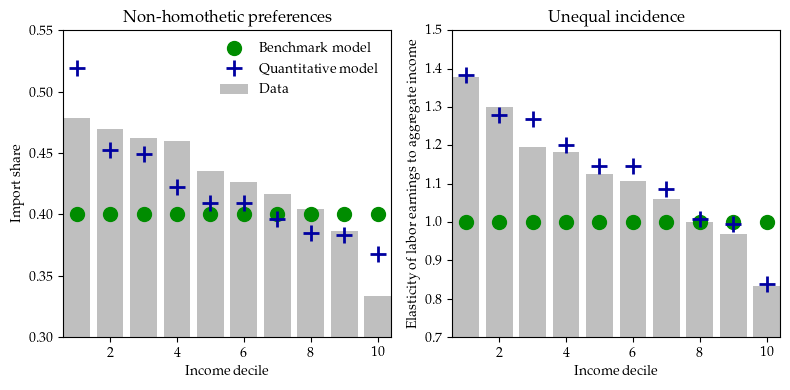

In [63]:
# Get data from plots
ss = calibrate_ss(calib = 'baseline', calib_list = calib_list, verbose=False)
_, _, _, _, _, _, _, _, _, _, _, _, _, _, dta_plots ,_, _, _ = aux_fn.calibration_mpc(ss, show_incdec=False)
ss2 = calibrate_ss(calib = 'quant', calib_list = calib_list, verbose=False)
_, _, _, _, _, _, _, _, _, _, _, _, _, _, dta_plots2 ,_, _, _ = aux_fn.calibration_mpc(ss2, show_incdec=False)

dta_plots['Cshare_decile_model'] = cshare_decile(dta_plots['cHshare_decile_model'],dta_plots['tradeshare_decile_model'])
dta_plots2['Cshare_decile_model'] = cshare_decile(dta_plots2['cHshare_decile_model'],dta_plots2['tradeshare_decile_model'])
dta_plots['Cshare_decile'] = cshare_decile(dta_plots['cHshare_decile'],dta_plots['tradeshare_decile'])

# plot
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.title('Output, RA + PCP')
plt.plot(np.arange(1, 11), dta_plots['tradeshare_decile_model'], 'o', markersize= 10, color = greenslide, label='Benchmark model', zorder= 2)
plt.plot(np.arange(1, 11), dta_plots2['tradeshare_decile_model'], '+', markersize= 12, markeredgewidth= 2, color = blueslide, label='Quantitative model', zorder= 3)
plt.bar(np.arange(1, 11), dta_plots['tradeshare_decile'], alpha=0.5, color = 'grey', label='Data', zorder= 1)
plt.title('Non-homothetic preferences')
plt.ylabel('Import share')
plt.xlabel('Income decile')
plt.legend(framealpha=0)
plt.ylim([0.3,0.55])
plt.subplot(1,2,2)
plt.title('Unequal incidence')
plt.plot(np.arange(1, 11), dta_plots['incidence_decile_model'], 'o', markersize= 10, color = greenslide)
plt.plot(np.arange(1, 11), dta_plots2['incidence_decile_model'], '+', markersize= 12, markeredgewidth= 2, color = blueslide)
plt.bar(np.arange(1, 11), dta_plots['incidence_decile'], alpha=0.5, color = 'grey')
plt.ylabel('Elasticity of labor earnings to aggregate income')
plt.xlabel('Income decile')
plt.ylim([0.7,1.5])
plt.tight_layout()
plt.show()

## Section 2

### Figure 1

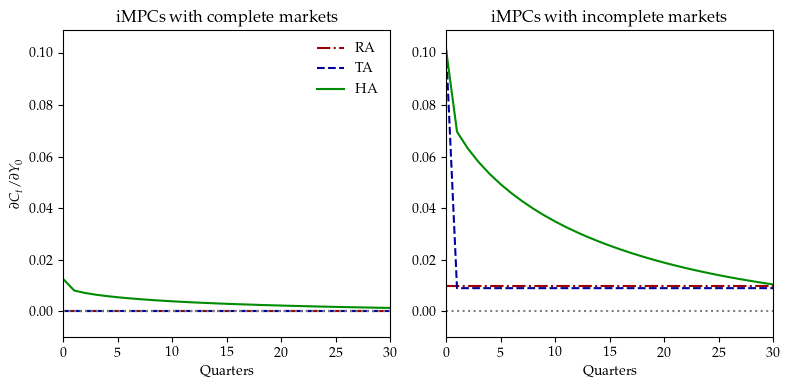

In [66]:
T = 400

# ss
chi = 0.1
ss = calibrate_ss(calib = 'baseline', calib_list = calib_list, eta=chi/1.6, eps_dcp=1, gamma=chi/1.6, verbose = False)
dr, dQ = aux_fn.rshock(0.01,0.85,ss,T,'rstar',Q0=1)

# HA-IM
M, Md, JCY = mod.get_M(ss,T)

# HA-CM
_, _, M_hacm = mod.CMHA_compute([chi],dQ,T,ss)

# TA-IM
ss['beta'] = 1/(1+ss['r'])
ss['markup_ss'] = calib_list['baseline']['markup_ss']
ss['share_h2m'] = ss['markup_ss']*(M[0,0]-(1-ss['beta']))/(1-ss['markup_ss']*(1-ss['beta']))
q = ss['beta']**np.arange(T)
Mc = 1/ss['markup_ss']*np.identity(T)
Mu = (1+(ss['share_h2m']*(ss['markup_ss']-1))/(ss['markup_ss']*(1-ss['share_h2m'])))*(1-ss['beta'])*np.ones((T,T))*q
M_taim = ss['share_h2m']*Mc + (1-ss['share_h2m'])*Mu

# TA-CM
M_tacm = ss['share_h2m']*Mc
M_tacm[0,0] = 0                 # transfer at t=0 in CM

# RA-IM
M_raim = (1-ss['beta'])*np.ones((T,T))*q

# RA-CM
M_racm = np.zeros((T,T))

# Plot
Tplot = 31
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.plot(M_racm[:Tplot,0], color=redslide, linestyle='dashdot', label=r'RA')
plt.plot(M_tacm[:Tplot,0], color=blueslide, linestyle='--', label=r'TA')
plt.plot(M_hacm[:Tplot,0], color=greenslide, label=r'HA')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.legend(framealpha=0, loc='upper right');
plt.ylim([-0.01,0.109])
plt.ylabel(r'$\partial C_t/\partial Y_0$')
plt.title(r'iMPCs with complete markets')
plt.xlabel('Quarters')
plt.subplot(1,2,2)
plt.plot(M_raim[:Tplot,0], color=redslide, linestyle='dashdot', label=r'RA')
plt.plot(M_taim[:Tplot,0], color=blueslide, linestyle='--', label=r'TA')
plt.plot(M[:Tplot,0], color=greenslide, label=r'HA')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim([-0.01,0.109])
plt.title(r'iMPCs with incomplete markets')
plt.xlabel('Quarters')
plt.tight_layout()
plt.show()

## Section 3

### Figure 2 and table 1

In [69]:
def RA_panel(chi, ss, dr, T, scale):
    
    alp = ss['alpha']
    ss['eta'] = chi/(2-alp)
    ss['gamma'] = chi/(2-alp)
    
    dY, dC, irf = {}, {}, {}
    irf['r'] = ss['r'] - np.zeros(T)
    irf['rstar'] = ss['rstar'] + scale*dr
    dQ = 1/(1+ss['r'])*np.triu(np.ones((T,T)), k=0)@dr
    
    # Complete markets RA
    dY_cm = (alp/(1-alp)*chi*np.identity(T)@dQ)
    dC_cm = np.zeros(T)
    
    # Incomplete markets RA
    y = opt.brentq(lambda yg: mod.RA_solution(1,yg,irf['r'],irf['rstar'],ss,T)[0], 0.8,1.2, xtol=1e-12, rtol = 1e-12)
    res, path_C, path_Q, path_Y, path_nfa, piw = mod.RA_solution(1,y,irf['r'],irf['rstar'],ss,T)
    dY_im = 1/scale*(path_Y - ss['y'])
    dC_im = 1/scale*(path_C - ss['C'])
    
    return dY_cm, dC_cm, dY_im, dC_im


Consumption responses at t=0
CM: RA = 0.000; TA = 0.000; HA = -0.023
IM: RA = -0.094; TA = -0.147; HA = -0.344


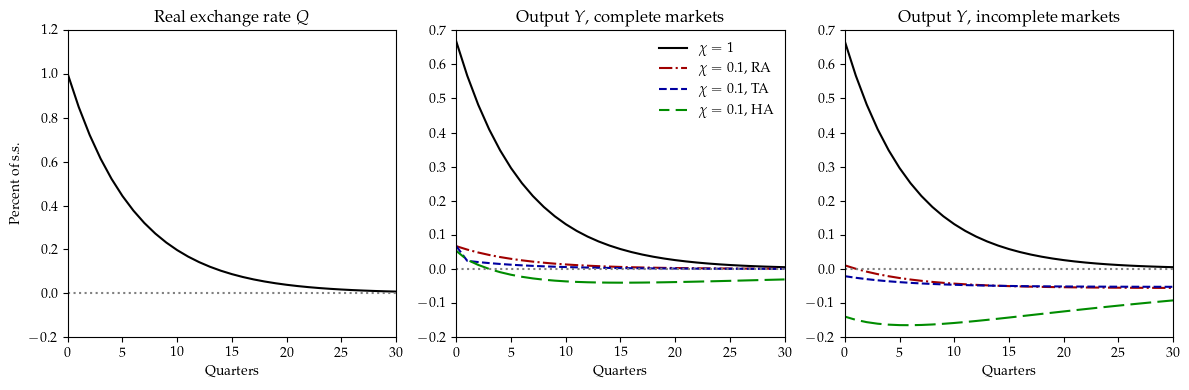

In [70]:
T = 400
chilist = [0.1,0.5,1]
dY, dC = {}, {}

# ss
ss = calibrate_ss(calib = 'baseline', calib_list = calib_list, eta=1, eps_dcp=1, gamma=1, verbose = False)
alp = ss['alpha']

# shock
dr, dQ = aux_fn.rshock(0.01,0.85,ss,T,'rstar',Q0=1)
scale = 1e-1

# HA-CM models
dY['CMHA'], dC['CMHA'], _ = mod.CMHA_compute(chilist,dQ,T,ss)

# HA-IM models
dY['IMHA'], dC['IMHA'] = {}, {}
M, Md, JCY = mod.get_M(ss,T)
for chi in chilist:
    dY['IMHA'][chi] = (np.linalg.inv(np.identity(T) - (1-alp)*M)@((alp/(1-alp)*chi*np.identity(T)-alp*M)@dQ))
    dC['IMHA'][chi] = (- alp/(1-alp)*M@dQ + M@dY['IMHA'][chi])

# TA-CM model
ss['beta'] = 1/(1+ss['r'])                          # adjust for permanent income agents
ss['share_h2m'] = M[0,0]*ss['markup_ss']
M_ta = 1/ss['markup_ss']*ss['share_h2m']*np.identity(T)
M_ta[0,0] = 0                 # transfer at t=0 in CM
dY['CMTA'], dC['CMTA'] = {}, {}
for chi in chilist:
    dY['CMTA'][chi] = (np.linalg.inv(np.identity(T) - (1-alp)*M_ta)@((alp/(1-alp)*chi*np.identity(T)-alp*M_ta)@dQ))
    dC['CMTA'][chi] = (- alp/(1-alp)*M_ta@dQ + M_ta@dY['CMTA'][chi])

# TA-IM model
ss['beta'] = 1/(1+ss['r'])
ss['share_h2m'] = ss['markup_ss']*(M[0,0]-(1-ss['beta']))/(1-ss['markup_ss']*(1-ss['beta']))
q = ss['beta']**np.arange(T)
Mc = 1/ss['markup_ss']*np.identity(T)
Mu = (1+(ss['share_h2m']*(ss['markup_ss']-1))/(ss['markup_ss']*(1-ss['share_h2m'])))*(1-ss['beta'])*np.ones((T,T))*q
M_taim = ss['share_h2m']*Mc + (1-ss['share_h2m'])*Mu
dY['IMTA'], dC['IMTA'] = {}, {}
for chi in chilist: 
    dY['IMTA'][chi] = (np.linalg.inv(np.identity(T) - (1-alp)*M_taim)@(alp*(chi/(1-alp)*np.identity(T)-M_taim)@dQ))
    dC['IMTA'][chi] = (- alp/(1-alp)*M_taim@dQ + M_taim@dY['IMTA'][chi])

# RA models
ss['beta'] = 1/(1+ss['r'])
dY['CMRA'], dY['IMRA'], dC['CMRA'], dC['IMRA'] = {}, {}, {}, {}
for chi in chilist:
    dY['CMRA'][chi], dC['CMRA'][chi], dY['IMRA'][chi], dC['IMRA'][chi] = RA_panel(chi, ss, dr, T, scale)

# Show consumption responses
print('\nConsumption responses at t=0')
print('CM: RA = %.3f; TA = %.3f; HA = %.3f' %(100*dC['CMRA'][0.1][0],100*dC['CMTA'][0.1][0],100*dC['CMHA'][0.1][0]))
print('IM: RA = %.3f; TA = %.3f; HA = %.3f' %(100*dC['IMRA'][0.1][0],100*dC['IMTA'][0.1][0],100*dC['IMHA'][0.1][0]))

# Plot
Tplot = 31
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.title('Real exchange rate $Q$')
plt.plot(100*dQ[:Tplot], color='k')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim([-0.2,1.2])
plt.ylabel('Percent of s.s.')
plt.xlabel('Quarters')
plt.subplot(1,3,2)
plt.plot(100*dY['CMRA'][1][:Tplot], color='k', label=r'$\chi=1$')
plt.plot(100*dY['CMRA'][0.1][:Tplot], color=redslide, linestyle='dashdot', label=r'$\chi=0.1$, RA')
plt.plot(100*dY['CMTA'][0.1][:Tplot], color=blueslide, linestyle='--', label=r'$\chi=0.1$, TA')
plt.plot(100*dY['CMHA'][0.1][:Tplot], color=greenslide, linestyle=(5,(10,3)), label=r'$\chi=0.1$, HA')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim([-0.2,0.7])
plt.title(r'Output $Y$, complete markets')
plt.legend(framealpha=0, loc='upper right');
plt.xlabel('Quarters')
plt.subplot(1,3,3)
plt.plot(100*dY['IMRA'][1][:Tplot], color='k', label=r'$\chi=1$')
plt.plot(100*dY['IMRA'][0.1][:Tplot], color=redslide, linestyle='dashdot', label=r'RA with $\chi=1$')
plt.plot(100*dY['IMTA'][0.1][:Tplot], color=blueslide, linestyle='--', label=r'TA with $\chi=0.5$')
plt.plot(100*dY['IMHA'][0.1][:Tplot], color=greenslide, linestyle=(5,(10,3)), label=r'HA with $\chi=0.1$')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim([-0.2,0.7])
plt.title(r'Output $Y$, incomplete markets')
plt.xlabel('Quarters')
plt.tight_layout()
plt.show()

### Figure 3

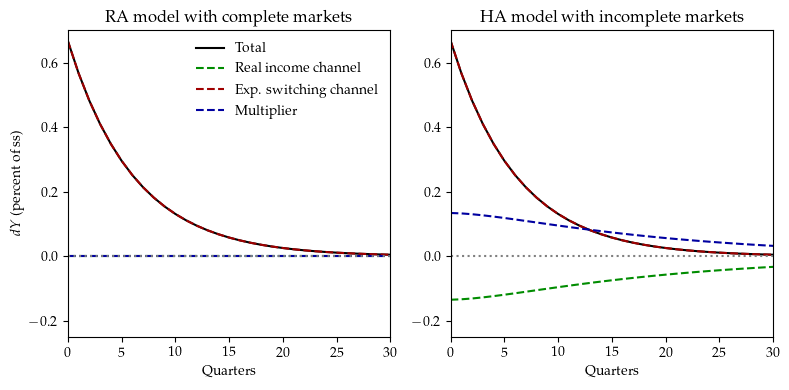

In [72]:
# get M in HA
T = 400
ss = calibrate_ss(calib = 'baseline', calib_list = calib_list, verbose = False)
M, Md, JCY = mod.get_M(ss,T)
alp = ss['alpha']

# Shock
dr, dQ = aux_fn.rshock(0.01,0.85,ss,T,'rstar',Q0=1)

# Compute dY in HA and RA and components
chi = 1
dY_GE= {}
dY_GE['ra'] = alp/(1-alp)*chi*np.identity(T)@dQ
dY_GE['ra_exp'] = (alp/(1-alp)*chi*np.identity(T)@dQ)
dY_GE['ra_inc'] = np.zeros(T)
dY_GE['ra_ge'] = np.zeros(T)
dY_GE['ha'] = (np.linalg.inv(np.identity(T) - (1-alp)*M)@((alp/(1-alp)*chi*np.identity(T)-alp*M)@dQ))
dY_GE['ha_exp'] = (alp/(1-alp)*chi*np.identity(T))@dQ
dY_GE['ha_inc'] = (-alp*M)@dQ
dY_GE['ha_ge'] = (1-alp)*M@dY_GE['ha']

# Plot GE
Tplot = 31
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.title(r'RA model with complete markets')
plt.plot(100*dY_GE['ra'][:Tplot], color='k', label='Total')
plt.plot(100*dY_GE['ra_inc'][:Tplot], color=greenslide, linestyle = '--', label='Real income channel')
plt.plot(100*dY_GE['ra_exp'][:Tplot], color=redslide, linestyle = '--', label='Exp. switching channel')
plt.plot(100*dY_GE['ra_ge'][:Tplot], color=blueslide, linestyle = '--', label='Multiplier')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.xlabel('Quarters')
plt.ylabel(r'$dY$ (percent of ss)')
plt.legend(framealpha=0)
plt.ylim([-0.25,0.7])
plt.subplot(1,2,2)
plt.title(r'HA model with incomplete markets')
plt.plot(100*dY_GE['ha'][:Tplot], color='k', label='Total')
plt.plot(100*dY_GE['ha_inc'][:Tplot], color=greenslide, linestyle = '--', label='Real income channel')
plt.plot(100*dY_GE['ha_exp'][:Tplot], color=redslide, linestyle = '--', label='Exp. switching channel')
plt.plot(100*dY_GE['ha_ge'][:Tplot], color=blueslide, linestyle = '--', label='Multiplier')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim([-0.25,0.7])
plt.xlabel('Quarters')
plt.tight_layout()
plt.show()

### Figure 4

In [74]:
def CompStatdY(chi_list, dictlist, rho=0, T=400): 
    
    # Define dict
    dY0_PE = {}
    dC0_PE = {}
    dY0_GE = {}
    dC0_GE = {}
    dNX0 = {}
    
    # get M
    ss = calibrate_ss(calib = 'baseline', calib_list = calib_list, eta=1/1.6, gamma=1/1.6, verbose = False)
    M, Md, JCY = mod.get_M(ss,T)
    alp = ss['alpha']
    
    # Shock 
    dr, dQ = aux_fn.rshock(1,rho,ss,T,'rstar',Q0=1)
    
    for id in dictlist:
        
        dY0_PE[id] = {}
        dY0_GE[id] = {}
        dC0_PE[id] = {}
        dC0_GE[id] = {}
        dNX0[id] = {}

        for i in range(chi_list.shape[0]):
                   
            if id == 'ha':

                dY0_PE[id][i] = ((alp/(1-alp)*chi_list[i]*np.identity(T)-alp*M)@dQ)[0]
                dY0 = (np.linalg.inv(np.identity(T) - (1-alp)*M)@((alp/(1-alp)*chi_list[i]*np.identity(T)-alp*M)@dQ))
                dY0_GE[id][i] = dY0[0]
                dC0_PE[id][i] = - (alp/(1-alp)*M@dQ)[0]
                dC0_GE[id][i] = (- alp/(1-alp)*M@dQ + M@dY0)[0]
                dNX0[id][i] = alp/(1-alp)*(chi_list[i]-1)*dQ[0] - alp*dC0_GE[id][i]
                
            elif id == 'ha-cm':

                dY, dC, _ = mod.CMHA_compute([chi_list[i]],dQ,T,ss)
                dY0_GE[id][i], dC0_GE[id][i] = dY[chi_list[i]][0], dC[chi_list[i]][0]
                dNX0[id][i] = alp/(1-alp)*(chi_list[i]-1)*dQ[0] - alp*dC0_GE[id][i]
                
            elif id == 'ra-cm': 
                
                dY0_GE[id][i] = (alp/(1-alp)*chi_list[i]*np.identity(T)@dQ)[0]
                dC0_GE[id][i] = 0
                dNX0[id][i] = alp/(1-alp)*(chi_list[i]-1)*dQ[0] - alp*dC0_GE[id][i]
                
            elif id == 'ra': 

                ss['beta'] = 1/(1+ss['r'])         # adjust for RA model
                _, _, dy, dc = RA_panel(chi_list[i], ss, dr, T, 0.1)
                dY0_GE[id][i] = dy[0]
                dC0_GE[id][i] = dc[0]
                dNX0[id][i] = alp/(1-alp)*(chi_list[i]-1)*dQ[0] - alp*dC0_GE[id][i]
                
            elif id == 'ta': 
                
                ss['beta'] = 1/(1+ss['r'])
                ss['share_h2m'] = ss['markup_ss']*(M[0,0]-(1-ss['beta']))/(1-ss['markup_ss']*(1-ss['beta']))
                q = ss['beta']**np.arange(T)
                Mc = 1/ss['markup_ss']*np.identity(T)
                Mu = (1+(ss['share_h2m']*(ss['markup_ss']-1))/(ss['markup_ss']*(1-ss['share_h2m'])))*(1-ss['beta'])*np.ones((T,T))*q
                M_ta = ss['share_h2m']*Mc + (1-ss['share_h2m'])*Mu                
                dY0 = (np.linalg.inv(np.identity(T) - (1-alp)*M_ta)@((alp/(1-alp)*chi_list[i]*np.identity(T)-alp*M_ta)@dQ))
                dY0_GE[id][i] = dY0[0]
                dC0_GE[id][i] = (- alp/(1-alp)*M_ta@dQ + M_ta@dY0)[0]                
                dNX0[id][i] = alp/(1-alp)*(chi_list[i]-1)*dQ[0] - alp*dC0_GE[id][i]

    return dY0_PE, dY0_GE, dC0_PE, dC0_GE, dNX0

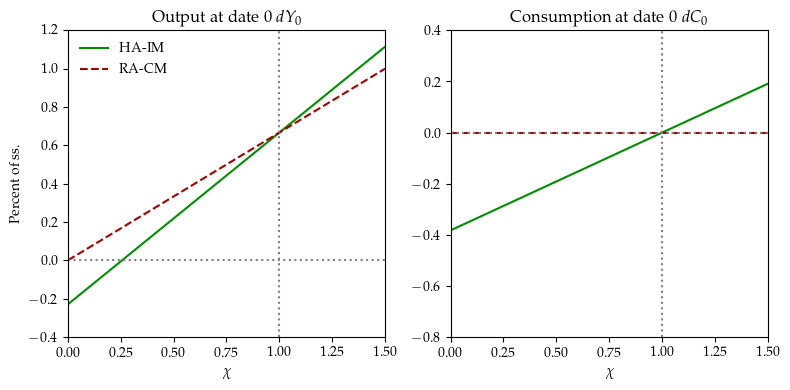

In [75]:
# Compute comparative statics
chi_list = np.linspace(1e-3,1.5,10)
dY0_PE, dY0_GE, dC0_PE, dC0_GE, dNX0 = CompStatdY(chi_list, ('ra','ha','ta','ra-cm','ha-cm'),rho=0.85)

# Plot
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.plot(chi_list, list(dY0_GE['ha'].values()), color=greenslide, label='HA-IM')
plt.plot(chi_list, list(dY0_GE['ra-cm'].values()), color=redslide, label='RA-CM', linestyle='--')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.axvline(x=1, color='#808080', linestyle=':')
plt.ylim(-0.4,1.2)
plt.xlim(0,1.5)
plt.ylabel(r'Percent of ss.')
plt.xlabel(r'$\chi$')
plt.title(r'Output at date 0 $dY_0$')
plt.legend(framealpha=0, loc = 'upper left');
plt.subplot(1,2,2)
plt.plot(chi_list, list(dC0_GE['ha'].values()), color=greenslide, label='HA-IM')
plt.plot(chi_list, list(dC0_GE['ra-cm'].values()), color=redslide, label='RA-CM', linestyle='--')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.axvline(x=1, color='#808080', linestyle=':')
plt.ylim(-0.8,0.4)
plt.xlim(0,1.5)
plt.xlabel(r'$\chi$')
plt.title(r'Consumption at date 0 $dC_0$')
plt.tight_layout()
plt.show()

## Section 4

### Figure 5

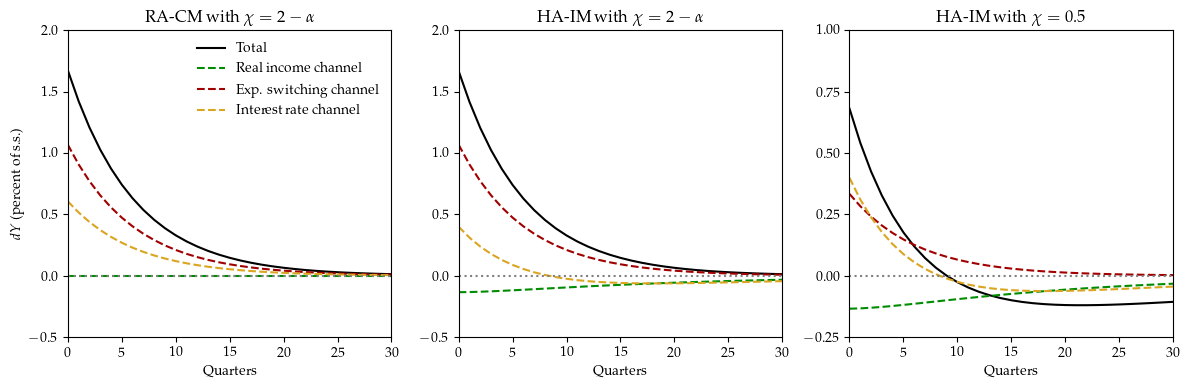

In [78]:
# get M
T = 400
ss = calibrate_ss(calib = 'baseline', calib_list = calib_list, verbose = False)
M, Md, JCY = mod.get_M(ss,T)
Mr = mod.get_Mr(ss,T)
U = np.triu(np.ones(T))
alp = ss['alpha']

# Shock 
dr, dQ = aux_fn.rshock(-0.01,0.85,ss,T,'r',Q0=1)

# Compute dY in HA and RA and components
chi = 1.6
dY_GE= {}
dY_GE['ra'] = - (1-alp)*U@dr + alp/(1-alp)*chi*np.identity(T)@dQ
dY_GE['ha'] = (np.linalg.inv(np.identity(T) - (1-alp)*M)@((1-alp)*Mr@dr+(alp/(1-alp)*chi*np.identity(T)-alp*M)@dQ))
dY_GE['ra_exp'] = (alp/(1-alp)*chi*np.identity(T)@dQ)
dY_GE['ra_inc'] = np.zeros(T)
dY_GE['ra_r'] = - (1-alp)*U@dr
dY_GE['ha_exp'] = (alp/(1-alp)*chi*np.identity(T))@dQ
dY_GE['ha_inc'] = (-alp*M)@dQ
dY_GE['ha_ge'] = (1-alp)*M@dY_GE['ha']
dY_GE['ha_r'] = (1-alp)*Mr@dr
dY_GE['ra_ge'] = np.zeros(T)
chi = 0.5
dY_GE['ha2'] = (np.linalg.inv(np.identity(T) - (1-alp)*M)@((1-alp)*Mr@dr+(alp/(1-alp)*chi*np.identity(T)-alp*M)@dQ))
dY_GE['ha_exp2'] = (alp/(1-alp)*chi*np.identity(T))@dQ
dY_GE['ha_inc2'] = (-alp*M)@dQ
dY_GE['ha_ge2'] = (1-alp)*M@dY_GE['ha']
dY_GE['ha_r2'] = (1-alp)*Mr@dr
dY_GE['ra_ge2'] = np.zeros(T)

# Plot GE
Tplot = 31
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
ylim=[-0.5,2]
plt.title(r'RA-CM with $\chi=2-\alpha$')
plt.plot(100*dY_GE['ra'][:Tplot], color='k', label='Total')
plt.plot(100*dY_GE['ra_inc'][:Tplot], color=greenslide, linestyle = '--', label='Real income channel')
plt.plot(100*dY_GE['ra_exp'][:Tplot], color=redslide, linestyle = '--', label='Exp. switching channel')
plt.plot(100*dY_GE['ra_r'][:Tplot], color='goldenrod', linestyle = '--', label='Interest rate channel')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.legend(framealpha=0)
plt.ylim(ylim)
plt.ylabel('$dY$ (percent of s.s.)')
plt.xlabel('Quarters')
plt.subplot(1,3,2)
plt.title(r'HA-IM with $\chi=2-\alpha$')
plt.plot(100*dY_GE['ha'][:Tplot], color='k', label='Total')
plt.plot(100*dY_GE['ha_inc'][:Tplot], color=greenslide, linestyle = '--', label='Real income channel')
plt.plot(100*dY_GE['ha_exp'][:Tplot], color=redslide, linestyle = '--', label='Exp. switching channel')
plt.plot(100*dY_GE['ha_r'][:Tplot], color='goldenrod', linestyle = '--', label='Interest rate channel')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim(ylim)
plt.xlabel('Quarters')
plt.subplot(1,3,3)
ylim=[-0.25,1]
plt.title(r'HA-IM with $\chi=0.5$')
plt.plot(100*dY_GE['ha2'][:Tplot], color='k', label='Total')
plt.plot(100*dY_GE['ha_inc2'][:Tplot], color=greenslide, linestyle = '--', label='Real income channel')
plt.plot(100*dY_GE['ha_exp2'][:Tplot], color=redslide, linestyle = '--', label='Exp. switching channel')
plt.plot(100*dY_GE['ha_r2'][:Tplot], color='goldenrod', linestyle = '--', label='Interest rate channel')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim(ylim)    
plt.yticks([-0.25,0,0.25,0.5,0.75,1])
plt.xlabel('Quarters')
plt.tight_layout()
plt.show()

## Section 5

### Table 2, figures 6 and 7: see calibration section above

### Figure 8

Steady state Walras law (CA identity) =  2.8792648265607568e-09
Steady state Walras law (CA identity) =  2.8792648265607568e-09
Steady state Walras law (CA identity) =  2.8792648265607568e-09
Walras =  0.00013885891302312103
Walras =  2.7347969559221585e-06
Walras =  2.6972465770297438e-05
LT NFA = -1.44e-05
LT NFA = -1.70e-06
LT NFA = 9.43e-06


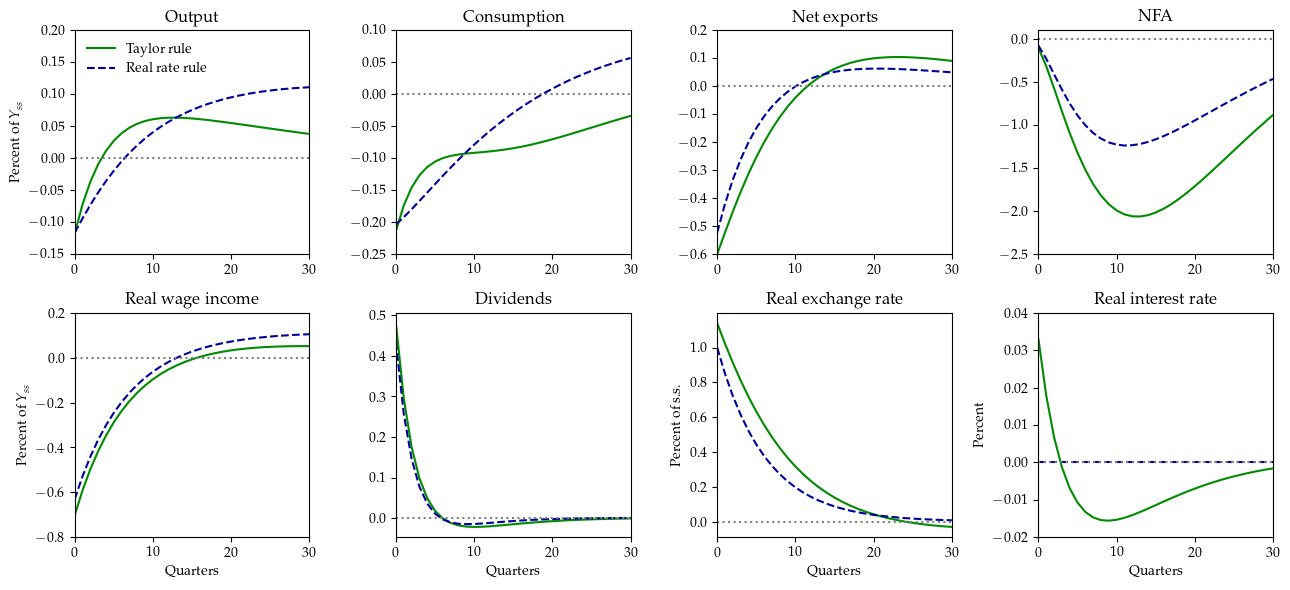

In [82]:
ss, G, shock, irf = {}, {}, {}, {}
m_list = ['realrate', 'taylor', 'chilow']

# Steady state
ss['taylor'] = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5)
ss['realrate'] = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66)
ss['chilow'] = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 0.1/1.6, gamma=0.1/1.6, theta_share = 1e-6, theta_w = 0.938, theta_X = 0.66, theta_p=0.66)

# Compute model jacobian
for m in m_list: 
    G[m] = mod_quant.solve_jacobian(ss[m], unknowns_quant, targets_quant, exogenous_quant, T=T)
    print('Walras = ', np.max(np.abs(G[m]['assets_clearing']['rstar'][:50,:50])))

# Shocks
shock, dQ = aux_fn.rshock(0.01,0.85,ss['realrate'],T,'rstar',Q0=1)

# Compute IRF
va={1:'y', 2:'C', 3:'netexports',4:'nfa',5:'atw_n',6:'div_tot',7:'Q',8:'r'}
for m in m_list: 
    irf[m]={}
    for i,k in va.items():
        irf[m][k]=G[m][k]['rstar'] @ shock 

# Check that NFA returns back to 0 
for m in m_list: print('LT NFA = %.2e' %(irf[m]['nfa'][-1]))

# Plot
Tplot = 31
titles = ['Output', 'Consumption', 'Net exports', 'NFA', 'Real wage income', 'Dividends', 'Real exchange rate', 'Real interest rate']
ylabels = ['Percent of $Y_{ss}$','Percent of $Y_{ss}$','Percent of $Y_{ss}$','Percent of $Y_{ss}$','Percent of $Y_{ss}$','Percent of $Y_{ss}$','Percent of s.s.','Percent']
plt.figure(figsize=(13,6))
for i,k in va.items():
    plt.subplot(2,4,i)
    plt.title(titles[i-1])
    plt.plot(100*irf['taylor'][k][0:Tplot], color=greenslide, label=r'Taylor rule')
    plt.plot(100*irf['realrate'][k][0:Tplot], color=blueslide, linestyle='--', label=r'Real rate rule')
    #plt.plot(100*irf['chilow'][k][0:Tplot], color=redslide, linestyle='dashdot', label=r'Real rate rule + $\chi=0.1$')
    plt.axhline(y=0, color='#808080', linestyle=':')
    if k == 'y': 
        plt.legend(framealpha=0, loc = 'upper left')
        plt.ylim([-0.15,0.2])
    if i >= 5: plt.xlabel('Quarters')
    if (i==1)|(i==5)|(i==7)|(i==8): plt.ylabel(ylabels[i-1])
    if k == 'C': plt.ylim([-0.25,0.1])
    if k == 'netexports': plt.ylim([-0.6,0.2])
    if k == 'nfa': plt.ylim([-2.5,0.1])
    if k == 'atw_n': plt.ylim([-0.8,0.2])
    if k == 'r': plt.ylim([-0.02,0.04])
plt.tight_layout()
plt.show()

### Figure 9

Steady state Walras law (CA identity) =  2.8792648265607568e-09


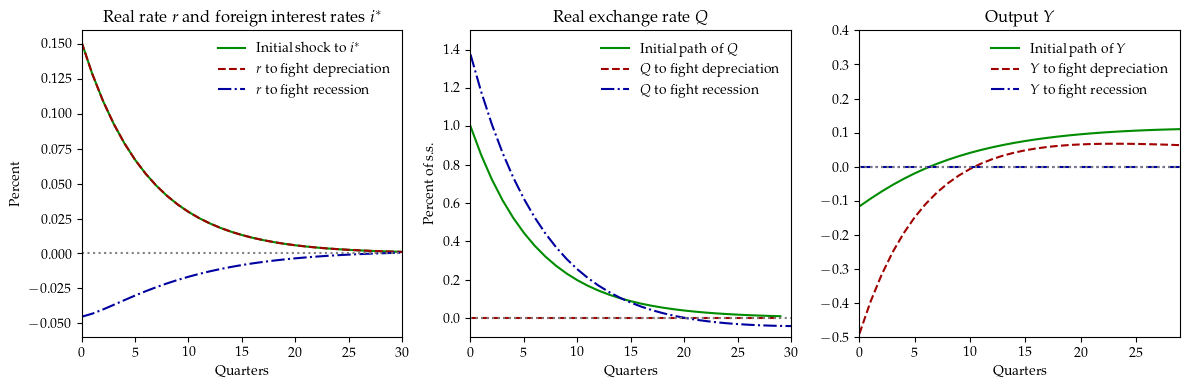

In [84]:
# Model steady state and jacobians
ss = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66)
G = mod_quant.solve_jacobian(ss, unknowns_quant, targets_quant, exogenous_quant, T=T)
shock, dQ = aux_fn.rshock(1,0.85,ss,T,'rstar',Q0=1)
J_yrstar = G['y']['rstar']
J_yr = G['y']['ishock']
J_Qrstar = G['Q']['rstar']
J_Qr = G['Q']['ishock']

# Fighting the depreciation
dr = - np.linalg.inv(J_Qr)@J_Qrstar

# Fighting the contraction
dr2 = - np.linalg.inv(J_yr)@J_yrstar

# Plot
Tplot = 31
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.title('Real rate $r$ and foreign interest rates $i^*$')
plt.plot(shock[:Tplot], color=greenslide, label='Initial shock to $i^*$');
plt.plot((dr@shock)[:Tplot], color=redslide, linestyle='--', label='$r$ to fight depreciation');
plt.plot((dr2@shock)[:Tplot], color=blueslide, linestyle='dashdot', label='$r$ to fight recession');
plt.axhline(y=0, color='#808080', linestyle=':')
plt.legend(framealpha=0)
plt.xlabel('Quarters')
plt.ylabel('Percent')
plt.ylim(-0.06,0.16)
plt.subplot(1,3,2)
plt.title('Real exchange rate $Q$')
plt.plot((J_Qrstar@shock)[:30], color=greenslide, label='Initial path of $Q$')
plt.plot((J_Qrstar@shock+J_Qr@dr@shock)[:30], color=redslide, linestyle='--', label='$Q$ to fight depreciation');
plt.plot((J_Qrstar@shock+J_Qr@dr2@shock)[:Tplot], color=blueslide, linestyle='dashdot', label='$Q$ to fight recession');
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim(-0.1,1.5)
plt.ylabel('Percent of s.s.')
plt.xlabel('Quarters')
plt.legend(framealpha=0)
plt.subplot(1,3,3)
plt.title('Output $Y$')
plt.plot((J_yrstar@shock)[:30], color=greenslide, label='Initial path of $Y$');
plt.plot((J_yrstar@shock+J_yr@dr@shock)[:30], color=redslide, linestyle='--', label='$Y$ to fight depreciation');
plt.plot((J_yrstar@shock+J_yr@dr2@shock)[:30], color=blueslide, linestyle='dashdot', label='$Y$ to fight recession');
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim(-0.5,0.4)
plt.xlabel('Quarters')
plt.legend(framealpha=0)
plt.tight_layout()
plt.show()

### Table 3

In [86]:
# Steady state
ss = {}
ss['1'] = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['2'] = calibrate_ss(calib = 'less_open', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['3'] = calibrate_ss(calib = 'high_mpc', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['4'] = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 1e-6, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['5'] = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, theta_I = 0.8, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['6'] = calibrate_ss(eta = 4, gamma = 4, theta_share = calib_list['theta_share'], markup_ss = calib_list['baseline']['markup_ss'], zeta_e = calib_list['quant']['zeta_e'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['7'] = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = 0.99, theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['9'] = calibrate_ss(zeta_e = 0, markup_ss= calib_list['quant']['markup_ss'], cbarF= calib_list['quant']['cbarF'], alpha= calib_list['quant']['alpha'], eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
m_list = ['1','2','3','4','5','6','7','9']
T = 800              # needs to be large enough

# Shock
dr, dQ = aux_fn.rshock(0.01,0.85,ss['1'],T,'rstar',Q0=1)

# Compute IRFs
G, irf = {}, {}
for m in m_list:
    G[m] = mod_quant.solve_jacobian(ss[m], unknowns_quant, targets_quant, exogenous_quant, T=T)
    irf[m] = aux_fn.irf_make(G[m],dr,'rstar',['y'],T)
    print('Walras = ', np.max(np.abs(G[m]['assets_clearing']['rstar'][:100,:100])))

# Compute impact, CIR and PV
dY0, dY_1y = {}, {}
J = (1/(1+ss['1']['r']))**np.arange(T)
for m in m_list:
    dY0[m] = 100*irf[m]['y'][0]
    dY_1y[m] = np.sum(100*irf[m]['y'][:4])
    
t1 = '\n\t' + 'Baseline ' + '\t' + 'Low alpha' + '\t' + 'High MPC' + '\t' + 'Full PCP'  + '\t' + 'Homothetic' 
t2 = 'dY0 ' + '\t' + ("{:.2f}").format(dY0['1']) + '   \t' + ("{:.2f}").format(dY0['2'])  + '        \t' + ("{:.2f}").format(dY0['3'])  + '        \t' + ("{:.2f}").format(dY0['4'])  + '        \t' + ("{:.2f}").format(dY0['6'])    
t5 = 'dY_1y ' + '\t' + ("{:.2f}").format(dY_1y['1']) + '    \t' + ("{:.2f}").format(dY_1y['2'])  + '        \t' + ("{:.2f}").format(dY_1y['3'])  + '        \t' + ("{:.2f}").format(dY_1y['4'])  + '        \t' + ("{:.2f}").format(dY_1y['6'])  
print(t1)
print(t2)
print(t5)
t1 = '\n\t' + 'Equal inc.' + '\t' + 'Low ST chi' + '\t' + 'Low E pt'
t2 = 'dY0 ' + '\t' + ("{:.2f}").format(dY0['9']) + '   \t' + ("{:.2f}").format(dY0['7']) + '   \t' + ("{:.2f}").format(dY0['5'])
t5 = 'dY_1y ' + ' \t' + ("{:.2f}").format(dY_1y['9'])+ '   \t' + ("{:.2f}").format(dY_1y['7'])+ '   \t' + ("{:.2f}").format(dY_1y['5'])
print(t1)
print(t2)
print(t5)

Walras =  1.3934820750974297e-05
Walras =  2.5987262022714175e-06
Walras =  2.1121460902356892e-05
Walras =  1.3849782351180173e-05
Walras =  1.9308586396427074e-09
Walras =  1.8921503146807073e-05
Walras =  1.0194659058715416e-05
Walras =  1.3924863537184695e-05

	Baseline 	Low alpha	High MPC	Full PCP	Homothetic
dY0 	-0.12   	-0.06        	-0.29        	-0.19        	-0.07
dY_1y 	-0.24    	-0.13        	-0.83        	-0.45        	-0.04

	Equal inc.	Low ST chi	Low E pt
dY0 	-0.10   	-0.36   	-0.03
dY_1y  	-0.18   	-1.16   	-0.14


### Table 4

In [88]:
# Steady state
ss = {}
ss['1'] = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['2'] = calibrate_ss(calib = 'quant', calib_list = calib_list, f_FY = -1, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['3'] = calibrate_ss(calib = 'quant', calib_list = calib_list, f_FY = -2, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['4'] = calibrate_ss(calib = 'quant', calib_list = calib_list, BbarY = -2, rho_B=0.5, lbda = 0, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['5'] = calibrate_ss(calib = 'quant', calib_list = calib_list, BbarY = -2, rho_B=0, lbda = 0, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['6'] = calibrate_ss(calib = 'quant', calib_list = calib_list, BbarY = -2, rho_B=0, lbda = 1, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
m_list = ['1','2','3','4','5','6']
T = 800              # needs to be large enough

# Shock
dr, dQ = aux_fn.rshock(0.01,0.85,ss['1'],T,'rstar',Q0=1)

# Compute IRFs
G, irf = {}, {}
for m in m_list:
    G[m] = mod_quant.solve_jacobian(ss[m], unknowns_quant, targets_quant, exogenous_quant, T=T)
    irf[m] = aux_fn.irf_make(G[m],dr,'rstar',['y','rstar','rpost_F','Transfer','B','C'],T)
    print('Walras = ', np.max(np.abs(G[m]['assets_clearing']['rstar'][:100,:100])))

# Compute impact, CIR and PV
dY0, dY_1y = {}, {}
J = (1/(1+ss['1']['r']))**np.arange(T)
for m in m_list:
    dY0[m] = 100*irf[m]['y'][0]
    dY_1y[m] = np.sum(100*irf[m]['y'][:4])
    
# Table
t1 = '\n\t' + 'Baseline ' + '\t' + 'Gross position' + '\t' + 'Gov, lump-sum' + '\t' + 'Gov, prop. tax' + '\t' + 'Gov, deficit'
t2 = 'dY0 ' + '\t' + ("{:.2f}").format(dY0['1']) + '        \t' + ("{:.2f}").format(dY0['3'])  + '        \t' + ("{:.2f}").format(dY0['6'])  + '        \t' + ("{:.2f}").format(dY0['5'])  + '        \t' + ("{:.2f}").format(dY0['4']) 
t5 = 'dY_1y ' + '\t' + ("{:.2f}").format(dY_1y['1']) + '        \t' + ("{:.2f}").format(dY_1y['3'])  + '        \t' + ("{:.2f}").format(dY_1y['6'])  + '        \t' + ("{:.2f}").format(dY_1y['5'])  + '        \t' + ("{:.2f}").format(dY_1y['4']) 

print(t1)
print(t2)
print(t5)

Walras =  1.3934820750974297e-05
Walras =  1.3613430312198194e-05
Walras =  1.3330422553886612e-05
Walras =  1.3332425894199695e-05
Walras =  1.3334561601241468e-05
Walras =  1.333000287655206e-05

	Baseline 	Gross position	Gov, lump-sum	Gov, prop. tax	Gov, deficit
dY0 	-0.12        	-0.21        	-0.36        	-0.26        	-0.24
dY_1y 	-0.24        	-0.55        	-0.79        	-0.65        	-0.63


## Appendix

### Figure A.1

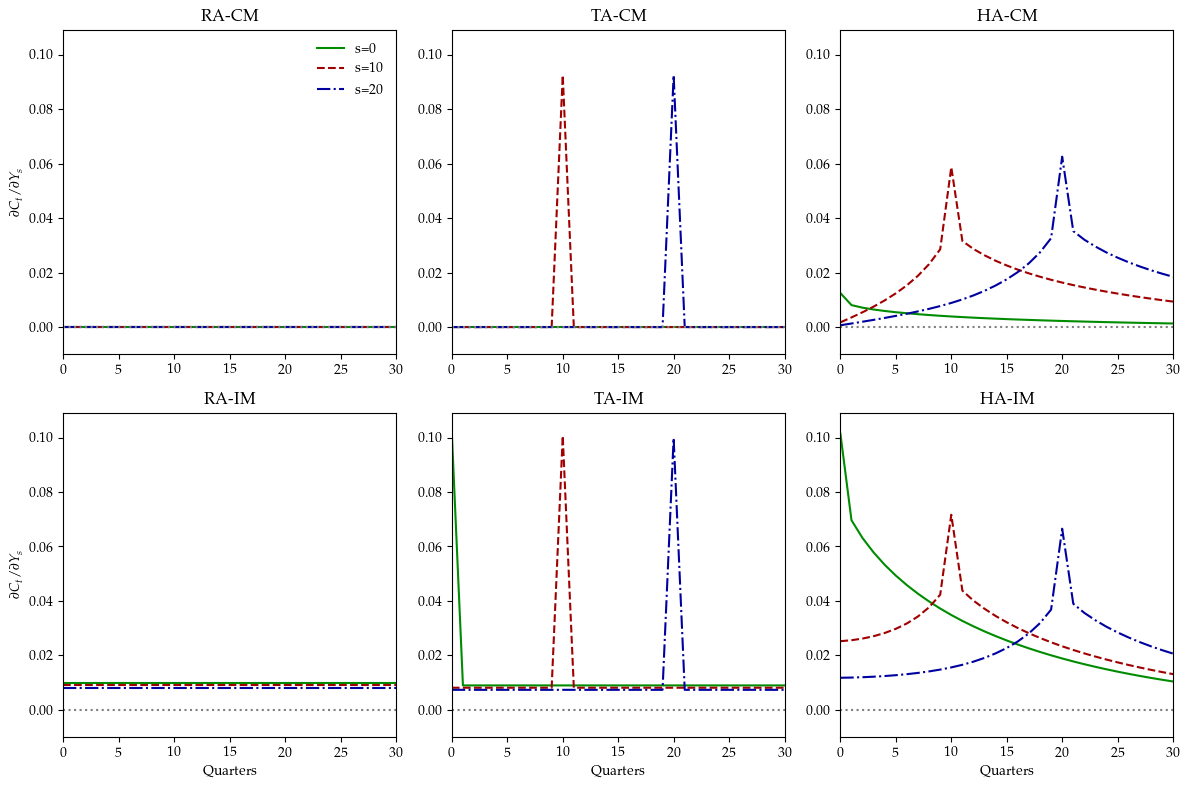

In [91]:
T = 400

# ss
chi = 0.1
ss = calibrate_ss(calib = 'baseline', calib_list = calib_list, eta=chi/1.6, eps_dcp=1, gamma=chi/1.6, verbose = False)
dr, dQ = aux_fn.rshock(0.01,0.85,ss,T,'rstar',Q0=1)

# HA-IM
M, Md, JCY = mod.get_M(ss,T)

# HA-CM
_, _, M_hacm = mod.CMHA_compute([chi],dQ,T,ss)

# TA-IM
ss['beta'] = 1/(1+ss['r'])
ss['markup_ss'] = calib_list['baseline']['markup_ss']
ss['share_h2m'] = ss['markup_ss']*(M[0,0]-(1-ss['beta']))/(1-ss['markup_ss']*(1-ss['beta']))
q = ss['beta']**np.arange(T)
Mc = 1/ss['markup_ss']*np.identity(T)
Mu = (1+(ss['share_h2m']*(ss['markup_ss']-1))/(ss['markup_ss']*(1-ss['share_h2m'])))*(1-ss['beta'])*np.ones((T,T))*q
M_taim = ss['share_h2m']*Mc + (1-ss['share_h2m'])*Mu

# TA-CM
M_tacm = ss['share_h2m']*Mc
M_tacm[0,0] = 0                 # transfer at t=0 in CM

# RA-IM
M_raim = (1-ss['beta'])*np.ones((T,T))*q

# RA-CM
M_racm = np.zeros((T,T))

# Plot
Tplot = 31
plt.figure(figsize=(12, 8))
plt.subplot(2,3,1)
plt.plot(M_racm[:Tplot,0], color=greenslide, label=r's=0')
plt.plot(M_racm[:Tplot,10], color=redslide, linestyle='--', label=r's=10')
plt.plot(M_racm[:Tplot,20], color=blueslide, linestyle='dashdot', label=r's=20')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.legend(framealpha=0, loc='upper right');
plt.ylim([-0.01,0.109])
plt.ylabel(r'$\partial C_t/\partial Y_s$')
plt.title(r'RA-CM')
plt.subplot(2,3,2)
plt.plot(M_tacm[:Tplot,0], color=greenslide, label=r's=0')
plt.plot(M_tacm[:Tplot,10], color=redslide, linestyle='--', label=r's=10')
plt.plot(M_tacm[:Tplot,20], color=blueslide, linestyle='dashdot', label=r's=20')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim([-0.01,0.109])
plt.title(r'TA-CM')
plt.subplot(2,3,3)
plt.plot(M_hacm[:Tplot,0], color=greenslide, label=r's=0')
plt.plot(M_hacm[:Tplot,10], color=redslide, linestyle='--', label=r's=10')
plt.plot(M_hacm[:Tplot,20], color=blueslide, linestyle='dashdot', label=r's=20')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim([-0.01,0.109])
plt.title(r'HA-CM')
plt.subplot(2,3,4)
plt.plot(M_raim[:Tplot,0], color=greenslide, label=r's=0')
plt.plot(M_raim[:Tplot,10], color=redslide, linestyle='--', label=r's=10')
plt.plot(M_raim[:Tplot,20], color=blueslide, linestyle='dashdot', label=r's=20')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim([-0.01,0.109])
plt.ylabel(r'$dC$')
plt.title(r'RA-IM')
plt.xlabel('Quarters')
plt.ylabel(r'$\partial C_t/\partial Y_s$')
plt.subplot(2,3,5)
plt.plot(M_taim[:Tplot,0], color=greenslide, label=r's=0')
plt.plot(M_taim[:Tplot,10], color=redslide, linestyle='--', label=r's=10')
plt.plot(M_taim[:Tplot,20], color=blueslide, linestyle='dashdot', label=r's=20')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim([-0.01,0.109])
plt.title(r'TA-IM')
plt.xlabel('Quarters')
plt.subplot(2,3,6)
plt.plot(M[:Tplot,0], color=greenslide, label=r's=0')
plt.plot(M[:Tplot,10], color=redslide, linestyle='--', label=r's=10')
plt.plot(M[:Tplot,20], color=blueslide, linestyle='dashdot', label=r's=20')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim([-0.01,0.109])
plt.title(r'HA-IM')
plt.xlabel('Quarters')
plt.tight_layout()
plt.show()

Figure A.2

Distance between quantitative model and int-IKC =  4.19e-08


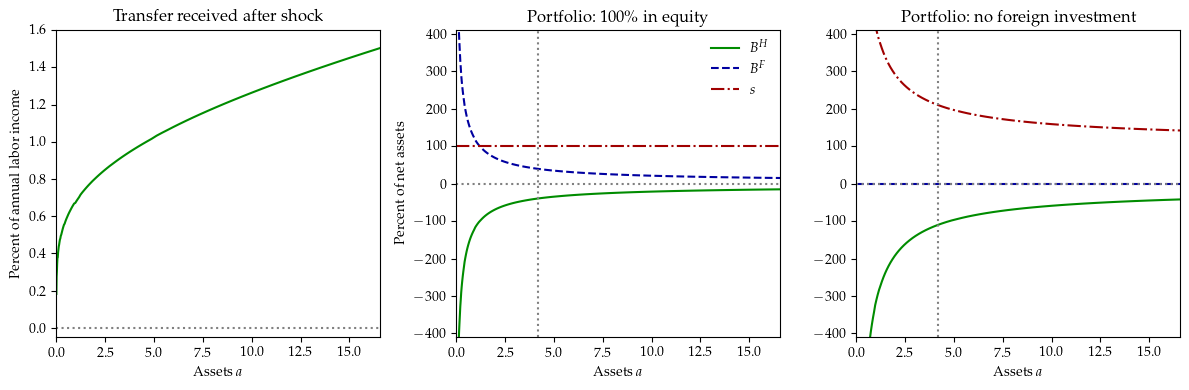

In [93]:
# Define steady state
chi = 0.1
ss = calibrate_ss(calib = 'baseline', calib_list = calib_list, eta = chi/1.6, gamma=chi/1.6, D=1, verbose=False)
dr, dQ = aux_fn.rshock(0.01,0.85,ss,T,'rstar',Q0=1)

# Compute model using int-IKC
dY, dC, M_withTf = mod.CMHA_compute([chi],dQ,T,ss)
dY, dC = dY[chi], dC[chi]

# Create model with M block instead of hh block
hh_M = sj.JacobianDict({'C': {'phh' : M_withTf, 'y' : M_withTf}})
hh_M = jacobiandict_block.JacobianDictBlock(hh_M)
hh_M.name = 'hh_M'
blocks_M = [hh_M, mod.hh_outputs_ds, mod.foreign_c_ds, mod.xrule, mod.xrule_foreign, mod.rsimple, mod.income_quant, mod.longbonds, mod.revaluation_quant, mod.profitcenters_quant, mod.UIP_quant, mod.assets_market, mod.goods_market, mod.CA_quant, mod.unions, mod.pi_to_P, mod.nkpc, mod.nkpc_X, mod.nkpc_I, mod.cpi, mod.prices, mod.eq_quant, mod.taylor, mod.fiscal]
mod_M = sj.create_model(blocks_M, name="Simple Model with M matrix")

# Compute IRFs
G = mod_M.solve_jacobian(ss, unknowns_quant, targets_quant, exogenous_quant, T=T)
va = ['y','C','rpost_F', 'rpost_H', 'rpost_firm','atw_n']
irf = aux_fn.irf_make(G,dr,'rstar',va,T)

# Check difference between models
diff = np.max(np.abs(irf['C']-dC)) + np.max(np.abs(irf['y']-dY))
print('Distance between quantitative model and int-IKC = % .2e' %(diff))

# Compute transfers in equilibrium and change in individual consumption
T_het, dc = mod.transfer_compute_eq(dQ,dY,ss)

# full firm ownership
Bh = T_het/(irf['rpost_H'][0] - irf['rpost_F'][0])
Bf = -Bh
s_hat = 0*T_het

# No foreign investment
Bh2 = T_het/(irf['rpost_H'][0] - irf['rpost_firm'][0])
Bf2 = 0*T_het
s_hat2 = - Bh2

# Share of workers with gross holdings larger than 100%
assets = Bh + Bf + s_hat+ss['a']
D = ss.internals['hh_HA']['D']
ide = int(ss['nE']/2)
above100 = 100*np.abs(Bh/assets) > 100
above100 = 100*np.abs(Bh[ide,:]/assets[ide,:]) > 100

# Figures
rgn = ss['a_grid'] < 4*ss['A']
Tplot = 11

# Plot: portfolio shares
assets = Bh + Bf + s_hat+ss['a']
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.plot(ss['a_grid'][rgn],100*T_het[ide,rgn]/(4*ss['atw_n']*ss['e_grid'][ide]),color=greenslide)
plt.axhline(y=0, color='#808080', linestyle=':')
plt.xlabel(r'Assets $a$')
plt.title(r'Transfer received after shock')
plt.ylabel('Percent of annual labor income')
plt.ylim(-100*0.0005,100*0.016)
plt.subplot(1,3,2)
plt.plot(ss['a_grid'][rgn],100*(Bh/assets)[ide,rgn],color=greenslide,label=r'$B^H$')
plt.plot(ss['a_grid'][rgn],100*(Bf/assets)[ide,rgn],color=blueslide,linestyle='--',label=r'$B^F$')
plt.plot(ss['a_grid'][rgn],100*((s_hat+ss['a'])/assets)[ide,rgn],color=redslide,linestyle='dashdot',label=r'$s$')
plt.axvline(x=ss['A'], color='#808080', linestyle=':')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.legend(framealpha=0)
plt.ylim(-100*4.1,100*4.1)
plt.xlabel(r'Assets $a$')
plt.title(r'Portfolio: 100\% in equity')
plt.ylabel('Percent of net assets')
plt.subplot(1,3,3)
plt.plot(ss['a_grid'][rgn],100*(Bh2/assets)[ide,rgn],color=greenslide)
plt.plot(ss['a_grid'][rgn],100*(Bf2/assets)[ide,rgn],color=blueslide,linestyle='--')
plt.plot(ss['a_grid'][rgn],100*((s_hat2+ss['a'])/assets)[ide,rgn],color=redslide,linestyle='dashdot')
plt.axvline(x=ss['A'], color='#808080', linestyle=':')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.ylim(-100*4.1,100*4.1)
plt.xlabel(r'Assets $a$')
plt.title(r'Portfolio: no foreign investment')
plt.tight_layout()
plt.show()

### Table A.1

In [95]:
calib_list['BRA'] = {'markup_ss': 1.0417933277713176,'cbarF': 0.0589434474472418,'alpha': 0.0861334945473949,'zeta_e': -0.1900643209755390}
calib_list['ARG'] = {'markup_ss': 1.0417742744475242,'cbarF': 0.0596658692864024,'alpha': 0.0960661256645533,'zeta_e': -0.1902137417512989}
calib_list['ITA'] = {'markup_ss': 1.0410401742044089,'cbarF': 0.0715874166540207,'alpha': 0.2352537118880804,'zeta_e': -0.1926685407767719}
calib_list['UK'] = {'markup_ss': 1.0409457008607625,'cbarF': 0.0749015973816235,'alpha': 0.2649430408005095,'zeta_e': -0.1933509724614159}
calib_list['KOR'] = {'markup_ss': 1.0407646848471239,'cbarF': 0.0811582365721215,'alpha': 0.3143540278526997,'zeta_e': -0.1946383128946809}
calib_list['SWE'] = {'markup_ss': 1.0404551855011477,'cbarF': 0.0918968635945846,'alpha': 0.3833299736859539,'zeta_e': -0.1968466004058789}
calib_list['THA'] = {'markup_ss': 1.0400285482099236,'cbarF': 0.1058493914699649,'alpha': 0.4519938106439186,'zeta_e': -0.1997172208110127}

In [96]:
# Steady state
ss = {}
ss['ARG'] = calibrate_ss(calib = 'ARG', calib_list = calib_list, theta_I = 0.78, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w=0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['BRA'] = calibrate_ss(calib = 'BRA', calib_list = calib_list, theta_I = 0.91, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w=0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['KOR'] = calibrate_ss(calib = 'KOR', calib_list = calib_list, theta_I = 0.93, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w=0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['MEX'] = calibrate_ss(calib = 'quant', calib_list = calib_list, theta_I = 1e-6, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w=0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['THA'] = calibrate_ss(calib = 'THA', calib_list = calib_list, theta_I = 0.96, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w=0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['FIN'] = calibrate_ss(calib = 'quant', calib_list = calib_list, theta_I = 1e-6, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w=0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['ITA'] = calibrate_ss(calib = 'ITA', calib_list = calib_list, theta_I = 0.94, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w=0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['SWE'] = calibrate_ss(calib = 'SWE', calib_list = calib_list, theta_I = 0.95, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w=0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['UK'] = calibrate_ss(calib = 'UK', calib_list = calib_list, theta_I = 0.99, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w=0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
m_list = ['ARG','BRA','MEX','KOR','THA','FIN','SWE','ITA','UK']
T = 800              # needs to be large enough

# Shock
dr, dQ = aux_fn.rshock(0.01,0.85,ss['ARG'],T,'rstar',Q0=1)

# Compute IRFs
G, irf = {}, {}
for m in m_list:
    G[m] = mod_quant.solve_jacobian(ss[m], unknowns_quant, targets_quant, exogenous_quant, T=T)
    irf[m] = aux_fn.irf_make(G[m],dr,'rstar',['y'],T)
    print('Walras = ', np.max(np.abs(G[m]['assets_clearing']['rstar'][:100,:100])))

# Compute impact, CIR and PV
dY0, dY_1y = {}, {}
J = (1/(1+ss['ARG']['r']))**np.arange(T)
for m in m_list:
    dY0[m] = 100*irf[m]['y'][0]
    dY_1y[m] = np.sum(100*irf[m]['y'][:4])

t1, t2, t3 = '\n\t', 'dY0\t', 'dY1y\t'
for cou in m_list:
    t1 += cou + '\t'
    t2 += ("{:.2f}").format(dY0[cou]) + '\t'
    t3 += ("{:.2f}").format(dY_1y[cou]) + '\t'

print(t1)
print(t2)
print(t3)

Walras =  1.2790061787448792e-09
Walras =  1.3218858230246155e-09
Walras =  1.3934820750974297e-05
Walras =  8.692888631145479e-10
Walras =  1.521200831966496e-09
Walras =  1.3934820750974297e-05
Walras =  1.7848982292179016e-09
Walras =  9.900014141805968e-10
Walras =  1.7992931589105865e-09

	ARG	BRA	MEX	KOR	THA	FIN	SWE	ITA	UK	
dY0	-0.03	-0.01	-0.12	0.01	0.03	-0.12	0.02	0.00	0.05	
dY1y	-0.11	-0.04	-0.24	0.02	0.13	-0.24	0.08	0.01	0.16	


#### Calibrate

Brazil (tradable share = 14%)

In [99]:
%%time

# Calibrate non-homotheticity and unequal incidence
if calib: 
    
    # Non-homotheticity (independent of unequal incidence so can do it separately)
    bnds = ((1.027,1.05), (0.04,0.25), (0.02,0.50))
    result = opt.minimize(lambda x: para_find_nonhomo(x[0],x[1],x[2],-0.265,tradable=0.14,beta_min=0.95,beta_max=0.99,verbose=False)[0],x0=[1.0285,0.08,0.065], bounds=bnds, tol = 1e-7)
    markup_ss,cbarF,alpha = result.x
    _, _ = para_find_nonhomo(markup_ss,cbarF,alpha,-0.265,tradable=0.14,beta_min=0.95,beta_max=0.99,verbose=True)
    
    # Unequal incidence (depends on non-homotheticity so do it second)
    bnds = [(-0.3,-0.05)]
    result = opt.minimize(lambda x: para_find_incidence(markup_ss,cbarF,alpha,x[0],verbose=False)[0],x0=[-0.265], bounds=bnds, tol = 1e-7)
    zeta_e = result.x[0]
    _, _ = para_find_incidence(markup_ss,cbarF,alpha,zeta_e,verbose=True)

else:

    markup_ss = calib_list['BRA']['markup_ss']
    cbarF = calib_list['BRA']['cbarF']
    alpha = calib_list['BRA']['alpha']
    zeta_e = calib_list['BRA']['zeta_e']

# Compute ss
ss2 = calibrate_ss(cbarF=cbarF, alpha=alpha, markup_ss=markup_ss, zeta_e=zeta_e, beta_min=0.9, beta_max=0.99)
print('\nParameters: markup = % .4f; cbarF = % .4f; alpha = % .4f; zeta_e = % .4f' %(ss2['markup_ss'],ss2['cbarF'],ss2['alpha'],ss2['zeta_e']))
sd_e2, mpc_avg_model2, mpc_avg_data2, mpc_sd_model2, mpc_sd_data2, tradeshare_avg_model2, tradeshare_avg_data2, tradeshare_sd_model2, tradeshare_sd_data2, corr_mpc_tradeshare_model2, corr_mpc_tradeshare_data2, mpc_w2, mpc_tf2, mpc_K2, dta_plots2, mpc_decile_beta2, incidence_sd_model2, incidence_sd_data2 = aux_fn.calibration_mpc(ss2)

Steady state Walras law (CA identity) =  2.4806596776727474e-09

Parameters: markup =  1.0418; cbarF =  0.0589; alpha =  0.0861; zeta_e = -0.1901
Model: quarterly mpc out of labor income =  0.1206; out of transfers =  0.2045; out of revaluation effects =  0.0621
Average mpc: model = 0.2045; data = 0.2045
Average import share: model = 0.14; data = 0.4
Standard deviation of import share: model = 0.04222; data = 0.04222
Standard deviation of incidence: model = 0.1519; data = 0.1519
CPU times: total: 469 ms
Wall time: 560 ms


Argentina (tradable share = 15%)

In [101]:
%%time

# Calibrate non-homotheticity and unequal incidence
if calib: 
    
    # Non-homotheticity (independent of unequal incidence so can do it separately)
    bnds = ((1.027,1.05), (0.04,0.25), (0.02,0.50))
    result = opt.minimize(lambda x: para_find_nonhomo(x[0],x[1],x[2],-0.265,tradable=0.15,beta_min=0.95,beta_max=0.99,verbose=False)[0],x0=[1.028,0.08,0.075], bounds=bnds, tol = 1e-7)
    markup_ss,cbarF,alpha = result.x
    _, _ = para_find_nonhomo(markup_ss,cbarF,alpha,-0.265,tradable=0.15,beta_min=0.95,beta_max=0.99,verbose=True)
    
    # Unequal incidence (depends on non-homotheticity so do it second)
    bnds = [(-0.3,-0.05)]
    result = opt.minimize(lambda x: para_find_incidence(markup_ss,cbarF,alpha,x[0],verbose=False)[0],x0=[-0.265], bounds=bnds, tol = 1e-7)
    zeta_e = result.x[0]
    _, _ = para_find_incidence(markup_ss,cbarF,alpha,zeta_e,verbose=True)

else:

    markup_ss = calib_list['ARG']['markup_ss']
    cbarF = calib_list['ARG']['cbarF']
    alpha = calib_list['ARG']['alpha']
    zeta_e = calib_list['ARG']['zeta_e']

# Compute ss
ss2 = calibrate_ss(cbarF=cbarF, alpha=alpha, markup_ss=markup_ss, zeta_e=zeta_e, beta_min=0.9, beta_max=0.99)
print('\nParameters: markup = % .4f; cbarF = % .4f; alpha = % .4f; zeta_e = % .4f' %(ss2['markup_ss'],ss2['cbarF'],ss2['alpha'],ss2['zeta_e']))
sd_e2, mpc_avg_model2, mpc_avg_data2, mpc_sd_model2, mpc_sd_data2, tradeshare_avg_model2, tradeshare_avg_data2, tradeshare_sd_model2, tradeshare_sd_data2, corr_mpc_tradeshare_model2, corr_mpc_tradeshare_data2, mpc_w2, mpc_tf2, mpc_K2, dta_plots2, mpc_decile_beta2, incidence_sd_model2, incidence_sd_data2 = aux_fn.calibration_mpc(ss2)

Steady state Walras law (CA identity) =  2.456063352695992e-09

Parameters: markup =  1.0418; cbarF =  0.0597; alpha =  0.0961; zeta_e = -0.1902
Model: quarterly mpc out of labor income =  0.1207; out of transfers =  0.2045; out of revaluation effects =  0.0622
Average mpc: model = 0.2045; data = 0.2045
Average import share: model = 0.15; data = 0.4
Standard deviation of import share: model = 0.04222; data = 0.04222
Standard deviation of incidence: model = 0.1519; data = 0.1519
CPU times: total: 172 ms
Wall time: 486 ms


Italy (tradable share = 29%)

In [103]:
%%time

# Calibrate non-homotheticity and unequal incidence
if calib: 
    
    # Non-homotheticity (independent of unequal incidence so can do it separately)
    bnds = ((1.027,1.05), (0.04,0.25), (0.04,0.50))
    result = opt.minimize(lambda x: para_find_nonhomo(x[0],x[1],x[2],-0.265,tradable=0.29,beta_min=0.95,beta_max=0.99,verbose=False)[0],x0=[1.028,0.095,0.215], bounds=bnds, tol = 1e-7)
    markup_ss,cbarF,alpha = result.x
    _, _ = para_find_nonhomo(markup_ss,cbarF,alpha,-0.265,tradable=0.29,beta_min=0.95,beta_max=0.99,verbose=True)
    
    # Unequal incidence (depends on non-homotheticity so do it second)
    bnds = [(-0.3,-0.05)]
    result = opt.minimize(lambda x: para_find_incidence(markup_ss,cbarF,alpha,x[0],verbose=False)[0],x0=[-0.265], bounds=bnds, tol = 1e-7)
    zeta_e = result.x[0]
    _, _ = para_find_incidence(markup_ss,cbarF,alpha,zeta_e,verbose=True)

else:

    markup_ss = calib_list['ITA']['markup_ss']
    cbarF = calib_list['ITA']['cbarF']
    alpha = calib_list['ITA']['alpha']
    zeta_e = calib_list['ITA']['zeta_e']

# Compute ss
ss2 = calibrate_ss(cbarF=cbarF, alpha=alpha, markup_ss=markup_ss, zeta_e=zeta_e, beta_min=0.9, beta_max=0.99)
print('\nParameters: markup = % .4f; cbarF = % .4f; alpha = % .4f; zeta_e = % .4f' %(ss2['markup_ss'],ss2['cbarF'],ss2['alpha'],ss2['zeta_e']))
sd_e2, mpc_avg_model2, mpc_avg_data2, mpc_sd_model2, mpc_sd_data2, tradeshare_avg_model2, tradeshare_avg_data2, tradeshare_sd_model2, tradeshare_sd_data2, corr_mpc_tradeshare_model2, corr_mpc_tradeshare_data2, mpc_w2, mpc_tf2, mpc_K2, dta_plots2, mpc_decile_beta2, incidence_sd_model2, incidence_sd_data2 = aux_fn.calibration_mpc(ss2)

Steady state Walras law (CA identity) =  1.7171850608121986e-09

Parameters: markup =  1.0410; cbarF =  0.0716; alpha =  0.2353; zeta_e = -0.1927
Model: quarterly mpc out of labor income =  0.1224; out of transfers =  0.2045; out of revaluation effects =  0.0629
Average mpc: model = 0.2045; data = 0.2045
Average import share: model = 0.29; data = 0.4
Standard deviation of import share: model = 0.04222; data = 0.04222
Standard deviation of incidence: model = 0.1519; data = 0.1519
CPU times: total: 46.9 ms
Wall time: 493 ms


UK (tradable share = 32%)

In [105]:
%%time

# Calibrate non-homotheticity and unequal incidence
if calib: 
    
    # Non-homotheticity (independent of unequal incidence so can do it separately)
    bnds = ((1.027,1.05), (0.04,0.25), (0.04,0.50))
    result = opt.minimize(lambda x: para_find_nonhomo(x[0],x[1],x[2],-0.265,tradable=0.32,beta_min=0.95,beta_max=0.99,verbose=False)[0],x0=[1.028,0.1,0.245], bounds=bnds, tol = 1e-7)
    markup_ss,cbarF,alpha = result.x
    _, _ = para_find_nonhomo(markup_ss,cbarF,alpha,-0.265,tradable=0.32,beta_min=0.95,beta_max=0.99,verbose=True)
    
    # Unequal incidence (depends on non-homotheticity so do it second)
    bnds = [(-0.3,-0.05)]
    result = opt.minimize(lambda x: para_find_incidence(markup_ss,cbarF,alpha,x[0],verbose=False)[0],x0=[-0.265], bounds=bnds, tol = 1e-7)
    zeta_e = result.x[0]
    _, _ = para_find_incidence(markup_ss,cbarF,alpha,zeta_e,verbose=True)

else:

    markup_ss = calib_list['UK']['markup_ss']
    cbarF = calib_list['UK']['cbarF']
    alpha = calib_list['UK']['alpha']
    zeta_e = calib_list['UK']['zeta_e']

# Compute ss
ss2 = calibrate_ss(cbarF=cbarF, alpha=alpha, markup_ss=markup_ss, zeta_e=zeta_e, beta_min=0.9, beta_max=0.99)
print('\nParameters: markup = % .4f; cbarF = % .4f; alpha = % .4f; zeta_e = % .4f' %(ss2['markup_ss'],ss2['cbarF'],ss2['alpha'],ss2['zeta_e']))
sd_e2, mpc_avg_model2, mpc_avg_data2, mpc_sd_model2, mpc_sd_data2, tradeshare_avg_model2, tradeshare_avg_data2, tradeshare_sd_model2, tradeshare_sd_data2, corr_mpc_tradeshare_model2, corr_mpc_tradeshare_data2, mpc_w2, mpc_tf2, mpc_K2, dta_plots2, mpc_decile_beta2, incidence_sd_model2, incidence_sd_data2 = aux_fn.calibration_mpc(ss2)

Steady state Walras law (CA identity) =  1.6280528036816122e-09

Parameters: markup =  1.0409; cbarF =  0.0749; alpha =  0.2649; zeta_e = -0.1934
Model: quarterly mpc out of labor income =  0.1227; out of transfers =  0.2045; out of revaluation effects =  0.0631
Average mpc: model = 0.2045; data = 0.2045
Average import share: model = 0.32; data = 0.4
Standard deviation of import share: model = 0.04222; data = 0.04222
Standard deviation of incidence: model = 0.1519; data = 0.1519
CPU times: total: 281 ms
Wall time: 505 ms


Korea (tradable share = 37%)

In [107]:
%%time

# Calibrate non-homotheticity and unequal incidence
if calib: 
    
    # Non-homotheticity (independent of unequal incidence so can do it separately)
    bnds = ((1.027,1.05), (0.04,0.25), (0.04,0.50))
    result = opt.minimize(lambda x: para_find_nonhomo(x[0],x[1],x[2],-0.265,tradable=0.37,beta_min=0.9,beta_max=0.99,verbose=False)[0],x0=[1.028,0.105,0.295], bounds=bnds, tol = 1e-7)
    markup_ss,cbarF,alpha = result.x
    _, _ = para_find_nonhomo(markup_ss,cbarF,alpha,-0.265,tradable=0.37,beta_min=0.9,beta_max=0.99,verbose=True)
    
    # Unequal incidence (depends on non-homotheticity so do it second)
    bnds = [(-0.3,-0.05)]
    result = opt.minimize(lambda x: para_find_incidence(markup_ss,cbarF,alpha,x[0],verbose=False)[0],x0=[-0.265], bounds=bnds, tol = 1e-7)
    zeta_e = result.x[0]
    _, _ = para_find_incidence(markup_ss,cbarF,alpha,zeta_e,verbose=True)

else:

    markup_ss = calib_list['KOR']['markup_ss']
    cbarF = calib_list['KOR']['cbarF']
    alpha = calib_list['KOR']['alpha']
    zeta_e = calib_list['KOR']['zeta_e']

# Compute ss
ss2 = calibrate_ss(cbarF=cbarF, alpha=alpha, markup_ss=markup_ss, zeta_e=zeta_e, r=0.01, beta_min=0.9, beta_max=0.99)
print('\nParameters: markup = % .4f; cbarF = % .4f; alpha = % .4f; zeta_e = % .4f' %(ss2['markup_ss'],ss2['cbarF'],ss2['alpha'],ss2['zeta_e']))
sd_e2, mpc_avg_model2, mpc_avg_data2, mpc_sd_model2, mpc_sd_data2, tradeshare_avg_model2, tradeshare_avg_data2, tradeshare_sd_model2, tradeshare_sd_data2, corr_mpc_tradeshare_model2, corr_mpc_tradeshare_data2, mpc_w2, mpc_tf2, mpc_K2, dta_plots2, mpc_decile_beta2, incidence_sd_model2, incidence_sd_data2 = aux_fn.calibration_mpc(ss2)

Steady state Walras law (CA identity) =  1.464737886536227e-09

Parameters: markup =  1.0408; cbarF =  0.0812; alpha =  0.3144; zeta_e = -0.1946
Model: quarterly mpc out of labor income =  0.1234; out of transfers =  0.2045; out of revaluation effects =  0.0633
Average mpc: model = 0.2045; data = 0.2045
Average import share: model = 0.37; data = 0.4
Standard deviation of import share: model = 0.04222; data = 0.04222
Standard deviation of incidence: model = 0.1519; data = 0.1519
CPU times: total: 188 ms
Wall time: 504 ms


Sweden (tradable share = 44%)

In [109]:
%%time

# Calibrate non-homotheticity and unequal incidence
if calib: 
    
    # Non-homotheticity (independent of unequal incidence so can do it separately)
    bnds = ((1.027,1.05), (0.04,0.25), (0.04,0.50))
    result = opt.minimize(lambda x: para_find_nonhomo(x[0],x[1],x[2],-0.265,tradable=0.44,beta_min=0.9,beta_max=0.99,verbose=False)[0],x0=[1.0275,0.12,0.365], bounds=bnds, tol = 1e-7)
    markup_ss,cbarF,alpha = result.x
    _, _ = para_find_nonhomo(markup_ss,cbarF,alpha,-0.265,tradable=0.44,beta_min=0.9,beta_max=0.99,verbose=True)
    
    # Unequal incidence (depends on non-homotheticity so do it second)
    bnds = [(-0.3,-0.05)]
    result = opt.minimize(lambda x: para_find_incidence(markup_ss,cbarF,alpha,x[0],verbose=False)[0],x0=[-0.265], bounds=bnds, tol = 1e-7)
    zeta_e = result.x[0]
    _, _ = para_find_incidence(markup_ss,cbarF,alpha,zeta_e,verbose=True)

else:

    markup_ss = calib_list['SWE']['markup_ss']
    cbarF = calib_list['SWE']['cbarF']
    alpha = calib_list['SWE']['alpha']
    zeta_e = calib_list['SWE']['zeta_e']

# Compute ss
ss2 = calibrate_ss(cbarF=cbarF, alpha=alpha, markup_ss=markup_ss, zeta_e=zeta_e, beta_min=0.9, beta_max=0.99)
print('\nParameters: markup = % .4f; cbarF = % .4f; alpha = % .4f; zeta_e = % .4f' %(ss2['markup_ss'],ss2['cbarF'],ss2['alpha'],ss2['zeta_e']))
sd_e2, mpc_avg_model2, mpc_avg_data2, mpc_sd_model2, mpc_sd_data2, tradeshare_avg_model2, tradeshare_avg_data2, tradeshare_sd_model2, tradeshare_sd_data2, corr_mpc_tradeshare_model2, corr_mpc_tradeshare_data2, mpc_w2, mpc_tf2, mpc_K2, dta_plots2, mpc_decile_beta2, incidence_sd_model2, incidence_sd_data2 = aux_fn.calibration_mpc(ss2)

Steady state Walras law (CA identity) =  2.5968880379423354e-09

Parameters: markup =  1.0405; cbarF =  0.0919; alpha =  0.3833; zeta_e = -0.1968
Model: quarterly mpc out of labor income =  0.1245; out of transfers =  0.2045; out of revaluation effects =  0.0637
Average mpc: model = 0.2045; data = 0.2045
Average import share: model = 0.44; data = 0.4
Standard deviation of import share: model = 0.04222; data = 0.04222
Standard deviation of incidence: model = 0.1519; data = 0.1519
CPU times: total: 250 ms
Wall time: 486 ms


Thailand (tradable share = 51%)

In [111]:
%%time

# Calibrate non-homotheticity and unequal incidence
if calib: 
    
    # Non-homotheticity (independent of unequal incidence so can do it separately)
    bnds = ((1.027,1.05), (0.04,0.25), (0.04,0.50))
    result = opt.minimize(lambda x: para_find_nonhomo(x[0],x[1],x[2],-0.265,tradable=0.51,beta_min=0.9,beta_max=0.99,verbose=False)[0],x0=[1.027,0.14,0.43], bounds=bnds, tol = 1e-7)
    markup_ss,cbarF,alpha = result.x
    _, _ = para_find_nonhomo(markup_ss,cbarF,alpha,-0.265,tradable=0.51,beta_min=0.9,beta_max=0.99,verbose=True)
    
    # Unequal incidence (depends on non-homotheticity so do it second)
    bnds = [(-0.3,-0.05)]
    result = opt.minimize(lambda x: para_find_incidence(markup_ss,cbarF,alpha,x[0],verbose=False)[0],x0=[-0.265], bounds=bnds, tol = 1e-7)
    zeta_e = result.x[0]
    _, _ = para_find_incidence(markup_ss,cbarF,alpha,zeta_e,verbose=True)

else:

    markup_ss = calib_list['THA']['markup_ss']
    cbarF = calib_list['THA']['cbarF']
    alpha = calib_list['THA']['alpha']
    zeta_e = calib_list['THA']['zeta_e']

# Compute ss
ss2 = calibrate_ss(cbarF=cbarF, alpha=alpha, markup_ss=markup_ss, zeta_e=zeta_e, beta_min=0.9, beta_max=0.99)
print('\nParameters: markup = % .4f; cbarF = % .4f; alpha = % .4f; zeta_e = % .4f' %(ss2['markup_ss'],ss2['cbarF'],ss2['alpha'],ss2['zeta_e']))
sd_e2, mpc_avg_model2, mpc_avg_data2, mpc_sd_model2, mpc_sd_data2, tradeshare_avg_model2, tradeshare_avg_data2, tradeshare_sd_model2, tradeshare_sd_data2, corr_mpc_tradeshare_model2, corr_mpc_tradeshare_data2, mpc_w2, mpc_tf2, mpc_K2, dta_plots2, mpc_decile_beta2, incidence_sd_model2, incidence_sd_data2 = aux_fn.calibration_mpc(ss2)

Steady state Walras law (CA identity) =  2.050970060452073e-09

Parameters: markup =  1.0400; cbarF =  0.1058; alpha =  0.4520; zeta_e = -0.1997
Model: quarterly mpc out of labor income =  0.1260; out of transfers =  0.2045; out of revaluation effects =  0.0642
Average mpc: model = 0.2045; data = 0.2045
Average import share: model = 0.51; data = 0.4
Standard deviation of import share: model = 0.04222; data = 0.04222
Standard deviation of incidence: model = 0.1519; data = 0.1519
CPU times: total: 203 ms
Wall time: 500 ms


### Figure A.3: see calibration section above

### Figure A.4

Country with worst ratio in 2017 = Tunisia


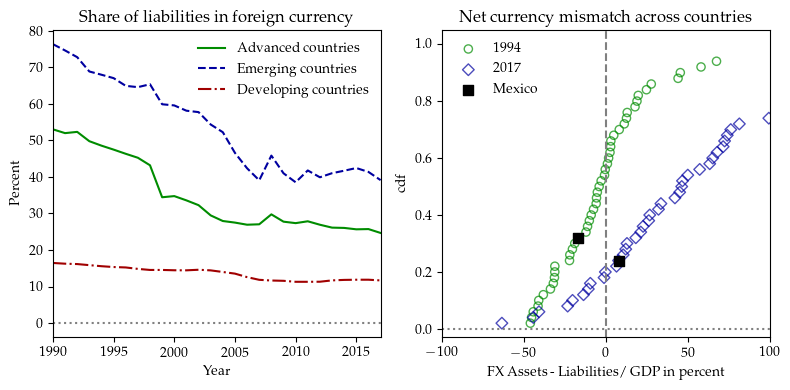

In [114]:
# extract data
data = pd.read_excel('data/data_currencymismatch.xlsx',sheet_name='Data JIE')

# List of countries
advanced = np.array(['United States', 'United Kingdom', 'Austria', 'Belgium', 'Denmark',
       'France', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Sweden',
       'Switzerland', 'Canada', 'Japan', 'Finland', 'Greece', 'Ireland',
       'Portugal', 'Spain', 'Australia', 'New Zealand'])
emerging = np.array(['Turkey', 'South Africa', 'Argentina', 'Brazil', 'Chile', 'Colombia',
       'Mexico', 'Peru', 'Israel', 'Egypt',
       'Hong Kong', 'India', 'Indonesia', 'Korea',
       'Malaysia', 'Pakistan', 'Philippines', 'Singapore', 'Thailand',
       'Russia', 'China,P.R.: Mainland',
       'Czech Republic', 'Hungary', 'Poland'])
developing = np.array(['Guatemala', 'Uruguay', 'Sri Lanka', 'Morocco', 'Tunisia', ])

# Currency mismatch
data['FC_mismatch'] = data['A_GDP']*data['w_A_FC'] - data['L_GDP']*data['w_L_FC']
countries = data[(data['year'] == 1994)]['country'].values
nb = countries.shape[0]
FC_mismatch = np.zeros((nb,2))
for i,cou in enumerate(countries):
    FC_mismatch[i,0] = data[(data['year'] == 1994)&(data['country'] == cou)]['FC_mismatch'].values[0]
    FC_mismatch[i,1] = data[(data['year'] == 2017)&(data['country'] == cou)]['FC_mismatch'].values[0]



# Share of liabilities in foreign currency
w_L_advanced = np.zeros((len(emerging),28))
w_L_emerging = np.zeros((len(emerging),28))
w_L_developing = np.zeros((len(emerging),28))
for j in range(28):
    for i,cou in enumerate(advanced): w_L_advanced[i,j] = data[(data['year'] == 1990+j)&(data['country'] == cou)]['w_L_FC'].values[0]
    for i,cou in enumerate(emerging): w_L_emerging[i,j] = data[(data['year'] == 1990+j)&(data['country'] == cou)]['w_L_FC'].values[0]
    for i,cou in enumerate(developing): w_L_developing[i,j] = data[(data['year'] == 1990+j)&(data['country'] == cou)]['w_L_FC'].values[0]
w_L_advanced = 100*np.nanmean(w_L_advanced,0)
w_L_emerging = 100*np.nanmean(w_L_emerging,0)
w_L_developing = 100*np.nanmean(w_L_developing,0)

# Data for Mexico
cdf = np.arange(1,nb+1)/nb
FC_mex = FC_mismatch[countries == 'Mexico'][0]
cdf_mex = [cdf[np.sort(FC_mismatch[:,0]) == FC_mex[0]] ,cdf[np.sort(FC_mismatch[:,1]) == FC_mex[1]]]

# Country with worst ratio
country_min = countries[FC_mismatch[:,1] == min(FC_mismatch[:,1])][0]
print(f'Country with worst ratio in 2017 = {country_min}')

# Plot 
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.title('Share of liabilities in foreign currency')
plt.plot(np.arange(1990,2018), w_L_advanced, color = greenslide, label = 'Advanced countries')
plt.plot(np.arange(1990,2018), w_L_emerging, color = blueslide, linestyle = '--', label = 'Emerging countries')
plt.plot(np.arange(1990,2018), w_L_developing, color = redslide, linestyle = 'dashdot', label = 'Developing countries')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.legend(framealpha=0)
plt.xlabel('Year')
plt.ylabel('Percent')
plt.subplot(1,2,2)
plt.title('Net currency mismatch across countries')
plt.scatter(np.sort(FC_mismatch[:,0]), cdf, color = greenslide, facecolors='none', alpha = 0.7, s = 35, label = '1994')
plt.scatter(np.sort(FC_mismatch[:,1]), cdf, marker = 'D', color = blueslide, s = 35, alpha = 0.7, facecolors='none', label = '2017')
plt.scatter(FC_mex[0], cdf_mex[0], marker = 's', color = 'k', s = 50, label = 'Mexico')
plt.scatter(FC_mex[1], cdf_mex[1], marker = 's', color = 'k', s = 50)
plt.axvline(x=0, color='#808080', linestyle='--')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.xlim([-100,100])
plt.ylabel('cdf')
plt.legend(framealpha=0)
plt.xlabel('FX Assets - Liabilities/ GDP in percent')
plt.tight_layout()
plt.show()

### Table A.2

In [116]:
chi = 1
theta_share = 1e-6

# Steady state
ss = {}
ss['1'] = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = chi/1.6, gamma = chi/1.6, theta_share = 1e-6, theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['2'] = calibrate_ss(calib = 'quant', calib_list = calib_list, f_FY = -1, eta = chi/1.6, gamma = chi/1.6, theta_share = theta_share, theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['3'] = calibrate_ss(calib = 'quant', calib_list = calib_list, f_FY = -2, eta = chi/1.6, gamma = chi/1.6, theta_share = theta_share, theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['4'] = calibrate_ss(calib = 'quant', calib_list = calib_list, BbarY = -2, rho_B=0.5, lbda = 0, eta = chi/1.6, gamma = chi/1.6, theta_share = theta_share, theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['5'] = calibrate_ss(calib = 'quant', calib_list = calib_list, BbarY = -2, rho_B=0, lbda = 0, eta = chi/1.6, gamma = chi/1.6, theta_share = theta_share, theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
ss['6'] = calibrate_ss(calib = 'quant', calib_list = calib_list, BbarY = -2, rho_B=0, lbda = 1, eta = chi/1.6, gamma = chi/1.6, theta_share = theta_share, theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose = False)
m_list = ['1','2','3','4','5','6']
T = 800              # needs to be large enough

# Shock
dr, dQ = aux_fn.rshock(0.01,0.85,ss['1'],T,'rstar',Q0=1)

# Compute IRFs
G, irf = {}, {}
for m in m_list:
    G[m] = mod_quant.solve_jacobian(ss[m], unknowns_quant, targets_quant, exogenous_quant, T=T)
    irf[m] = aux_fn.irf_make(G[m],dr,'rstar',['y','rstar','rpost_F','Transfer','B','C'],T)
    print('Walras = ', np.max(np.abs(G[m]['assets_clearing']['rstar'][:100,:100])))

# Compute impact, CIR and PV
dY0, dY_1y = {}, {}
J = (1/(1+ss['1']['r']))**np.arange(T)
for m in m_list:
    dY0[m] = 100*irf[m]['y'][0]
    dY_1y[m] = np.sum(100*irf[m]['y'][:4])
    
# Table
t1 = '\n\t' + 'Benchmark ' + '\t' + 'Mutual fund' + '\t' + 'Gov, lump-sum' + '\t' + 'Gov, prop. tax' + '\t' + 'Gov, deficit'
t2 = 'dY0 ' + '\t' + ("{:.2f}").format(dY0['1']) + '        \t' + ("{:.2f}").format(dY0['3'])  + '        \t' + ("{:.2f}").format(dY0['6'])  + '        \t' + ("{:.2f}").format(dY0['5'])  + '        \t' + ("{:.2f}").format(dY0['4']) 
t5 = 'dY_1y ' + '\t' + ("{:.2f}").format(dY_1y['1']) + '        \t' + ("{:.2f}").format(dY_1y['3'])  + '        \t' + ("{:.2f}").format(dY_1y['6'])  + '        \t' + ("{:.2f}").format(dY_1y['5'])  + '        \t' + ("{:.2f}").format(dY_1y['4']) 

print(t1)
print(t2)
print(t5)

Walras =  1.2212126306532234e-05
Walras =  1.1774051517643436e-05
Walras =  1.1313405506419016e-05
Walras =  1.132137133774691e-05
Walras =  1.1325549234775245e-05
Walras =  1.1332672868513693e-05

	Benchmark 	Mutual fund	Gov, lump-sum	Gov, prop. tax	Gov, deficit
dY0 	0.31        	0.23        	0.03        	0.16        	0.19
dY_1y 	1.38        	1.17        	0.86        	1.05        	1.08


### Figure A.5

Steady state Walras law (CA identity) =  2.8792648265607568e-09
Steady state Walras law (CA identity) =  2.8792648265607568e-09
Walras =  2.079701946586243e-06
Walras =  2.797590449944709e-06


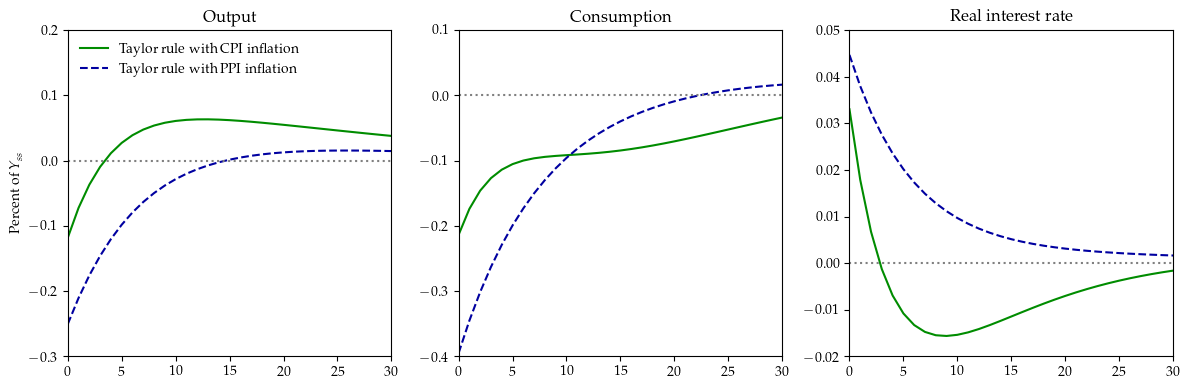

In [118]:
ss, G, shock, irf = {}, {}, {}, {}
m_list = ['taylor_ppi', 'taylor']

# Steady state
ss['taylor'] = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5)
ss['taylor_ppi'] = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = 0.938, theta_X = 0.66, theta_p=0.66, realrate=0, phi_piHH = 1.5)

# Compute model jacobian
for m in m_list: 
    G[m] = mod_quant.solve_jacobian(ss[m], unknowns_quant, targets_quant, exogenous_quant, T=T)
    print('Walras = ', np.max(np.abs(G[m]['assets_clearing']['rstar'][:50,:50])))

# Shocks
shock, dQ = aux_fn.rshock(0.01,0.85,ss['taylor_ppi'],T,'rstar',Q0=1)

# Compute IRF
va={1:'y', 2:'C', 3:'r'}
for m in m_list: 
    irf[m]={}
    for i,k in va.items():
        irf[m][k]=G[m][k]['rstar'] @ shock 

# Plot
Tplot = 31
titles = ['Output', 'Consumption', 'Real interest rate']
ylabels = ['Percent of $Y_{ss}$','Percent of $Y_{ss}$','Percent']
plt.figure(figsize=(12,4))
for i,k in va.items():
    plt.subplot(1,3,i)
    plt.title(titles[i-1])
    plt.plot(100*irf['taylor'][k][0:Tplot], color=greenslide, label=r'Taylor rule with CPI inflation')
    plt.plot(100*irf['taylor_ppi'][k][0:Tplot], color=blueslide, linestyle='--', label=r'Taylor rule with PPI inflation')
    #plt.plot(100*irf['chilow'][k][0:Tplot], color=redslide, linestyle='dashdot', label=r'Real rate rule + $\chi=0.1$')
    plt.axhline(y=0, color='#808080', linestyle=':')
    if k == 'y': 
        plt.legend(framealpha=0, loc = 'upper left')
        plt.ylim([-0.3,0.2])
    if i >= 5: plt.xlabel('Quarters')
    if (i==1)|(i==5)|(i==7)|(i==8): plt.ylabel(ylabels[i-1])
    if k == 'C': plt.ylim([-0.4,0.1])
    if k == 'r': plt.ylim([-0.02,0.05])
plt.tight_layout()
plt.show()

### Figure A.6

In [120]:
def CA_f(C,Q,nfa,eta,alpha,r):
    Y = (C-r*nfa)/mod.phh_f(Q,eta,alpha)
    return Y

def goodsclearing_f(C,Q,nfa,eta,alpha,eps_dcp,Cstar,gamma,r):
    res = (CA_f(C,Q,nfa,eta,alpha,r) - alpha*mod.phf_f(Q, eta, alpha)**(-gamma*eps_dcp)*Cstar)/((1-alpha)*mod.phh_f(Q,eta,alpha)**(-eta)) - C
    return res

def unions_ss_ff(C,Q,nfa,eta,alpha,eps_dcp,Cstar,gamma,eis,r,ss):
    res = ((ss['markup_ss']*ss['markup_ss'])*ss['vphi']*(CA_f(C,Q,nfa,eta,alpha,r)/ss['Z'])**(1/ss['frisch'])/(mod.phh_f(Q,eta,alpha)*ss['Z']))**(-eis) - C
    return res

def ss_res_f(C,Q,nfa,ss):
    res1 = goodsclearing_f(C,Q,nfa,ss['eta'],ss['alpha'],ss['eps_dcp'],ss['Cstar'],ss['gamma'],ss['r'])
    res2 = unions_ss_ff(C,Q,nfa,ss['eta'],ss['alpha'],ss['eps_dcp'],ss['Cstar'],ss['gamma'],ss['eis'],ss['r'],ss)
    return np.sqrt(res1**2+res2**2)

def res_imra_quant(nfa,ss0,model,unknowns,targets,shock,H_U_factored):
    ss = ss0.copy()
    C, Q = opt.minimize(lambda x: ss_res_f(x[0],x[1],nfa,ss), x0 = [1.,1.], bounds=((0.99, 1.01), (0.99, 1.01)), tol = 1e-12).x
    ss['C'] = C
    ss['Q'] = Q
    irff = model.solve_impulse_nonlinear(ss, unknowns, targets, shock, H_U_factored=H_U_factored, ss_initial = ss0)
    res = irff['nfa'][-1] - nfa
    return res, irff, C, Q

Steady state Walras law (CA identity) =  2.8792648265607568e-09
Steady state Walras law (CA identity) =  2.9952385016684957e-09
New ss value for C = 0.9999990876; Q = 1.0000002160; nfa = -1.15e-04; piw = -3.18e-07


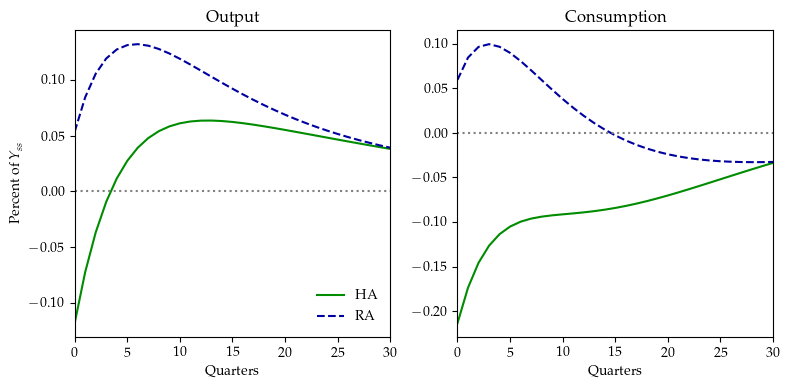

In [121]:
T = 800
theta_w = 0.938

# Steady state
ss = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = theta_w, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5)

# RA model
ss_ra = calibrate_ss(markup_ss = calib_list['baseline']['markup_ss'], eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w = theta_w, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5)
ss_ra['beta'] = 1/(1+ss_ra['r'])
ss_ra['C'] = ss_ra['r'] * ss_ra['A'] + ss_ra['atw_n']
ss_ra['cF'] = ss_ra['alpha']*ss_ra['C']
ss_ra['cH'] = (1-ss_ra['alpha'])*ss_ra['C']
ss_ra['CT'] = ss_ra['cH'] + ss_ra['cF']
ss_ra['cHstar'] = ss_ra['y'] - ss_ra['cH']
ss_ra['Cstar'] = ss_ra['cHstar']/ss_ra['alphastar']
ss_ra['netexports'] = ss_ra['y'] - ss_ra['cF'] - ss_ra['cH'] 
ss_ra['Css_ra'] = ss_ra['CT']
ss_ra['vphi'] = ss_ra['atw'] * 1/ss_ra['markup_ss'] * ss_ra['CT']**(-1/ss_ra['eis']) * ss_ra['n']**(-1/ss_ra['frisch'])
for v in ['uip', 'Cres', 'Ares', 'pires', 'piwres', 'piFHres', 'PFHres', 'piHHres', 'piHFres', 'PHHres', 'PHFres', 'nfares', 'Pres', 'qres', 'qHres', 'xstarres_F', 'xstarres', 'xres_F', 'xres', 'goods_clearing', 'Bres', 'real_wage', 'fisher']:
    ss_ra[v] = 0
ss_ra['real_mc'] = ss_ra['w']/(ss_ra['Z']*ss_ra['phh'])
ss_ra['rpost_firm'] = ss_ra['r']

# Shocks
scale = 1e-4
dr, dQ = aux_fn.rshock(scale,0.85,ss,T,'rstar',Q0=1)
shock = {"rstar": dr}
va = ['y','C','nfa','r','Q','piw','piHH','pi','i']

# HA model
G = mod_quant.solve_jacobian(ss, unknowns_quant, targets_quant, exogenous_quant, T=T)
irf_ha = aux_fn.irf_make(G,dr/scale/100,'rstar',va,T)

# RA model
mod_quant_ra.solve_impulse_nonlinear_options['verbose'] = False
mod_quant_ra.solve_impulse_nonlinear_options['maxit'] = 60
mod_quant_ra.solve_impulse_nonlinear_options['tol'] = 1e-8
H_U = mod_quant_ra.jacobian(ss_ra, unknowns_quant, targets_quant, T=T)
H_U_factored = FactoredJacobianDict(H_U, T)
nfa = opt.brentq(lambda x: res_imra_quant(x,ss_ra,mod_quant_ra,unknowns_quant,targets_quant,shock,H_U_factored)[0], -0.1,0.1, xtol=1e-12, rtol = 1e-12)
res, irf_ra, C, Q = res_imra_quant(nfa,ss_ra,mod_quant_ra,unknowns_quant,targets_quant,shock,H_U_factored)
for v,k in irf_ra.items(): irf_ra[v] = irf_ra[v]/scale/100         # Rescale 
irf_ra['C'] += (C - ss_ra['C'])/scale/100 
irf_ra['Q'] += (Q - ss_ra['Q'])/scale/100
print('New ss value for C = %.10f; Q = %.10f; nfa = %.2e; piw = %.2e'%(C,Q,nfa,irf_ra['piw'][-1]))

# Plot
Tplot = 31
va2 = ['y', 'C', 'nfa', 'Q', 'r', 'i', 'piHH', 'pi']
titles = ['Output', 'Consumption', 'NFA', 'Real exchange rate', 'Real interest rate', 'Nominal interest rate', 'PPI inflation rate', 'CPI inflation rate']
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('Output')
k = 'y'
plt.plot(100*irf_ha[k][0:Tplot], color=greenslide, label=r'HA')
plt.plot(100*irf_ra[k][0:Tplot], color=blueslide, linestyle='--', label=r'RA')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.legend(framealpha=0, loc = 'lower right') 
plt.ylabel('Percent of $Y_{ss}$')
plt.xlabel('Quarters')
plt.subplot(1,2,2)
plt.title('Consumption')
k = 'C'
plt.plot(100*irf_ha[k][0:Tplot], color=greenslide, label=r'HA')
plt.plot(100*irf_ra[k][0:Tplot], color=blueslide, linestyle='--', label=r'RA')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.xlabel('Quarters')
plt.tight_layout()
plt.show()

### Figure A.7

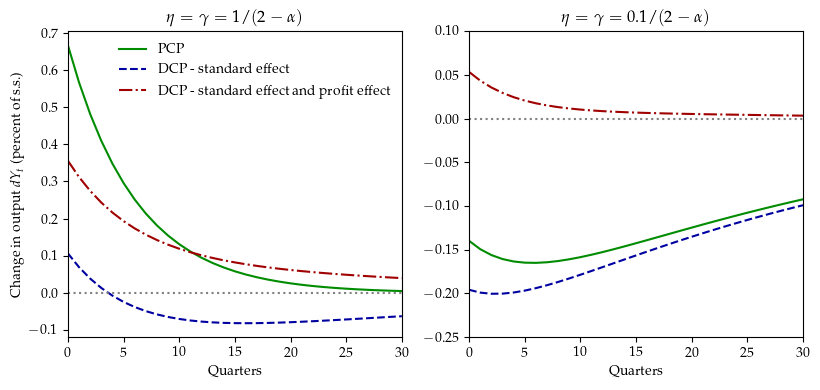

In [123]:
# get M
T = 400
ss = calibrate_ss(calib = 'baseline', calib_list = calib_list, verbose = False)
M, Md, JCY = mod.get_M(ss,T)
alp = ss['alpha']

# Shock
dr, dQ = aux_fn.rshock(0.01,0.85,ss,T,'rstar',Q0=1)

# Compute dY for eta=gamma=0.1
dY_GE= {}
eta = gamma = 0.1/(2-alp)
chi = eta*(1-alp) + 1*gamma
dY_GE['ha'] = np.linalg.inv(np.identity(T) - (1-alp)*M)@(alp/(1-alp)*chi*np.identity(T)@dQ-alp*(M-0*(1-1)*Md)@dQ)
chi = eta*(1-alp) + 0*gamma
dY_GE['ha_dcp'] = np.linalg.inv(np.identity(T) - (1-alp)*M)@(alp/(1-alp)*chi*np.identity(T)@dQ-alp*(M-0*(1-0)*Md)@dQ)
dY_GE['ha_dcp_localpc'] = np.linalg.inv(np.identity(T) - (1-alp)*M)@(alp/(1-alp)*chi*np.identity(T)@dQ-alp*(M-1*(1-0)*Md)@dQ)

# Compute dY for eta=gamma=1
eta = gamma = 1/(2-alp)
chi = eta*(1-alp) + 1*gamma
dY_GE['ha2'] = np.linalg.inv(np.identity(T) - (1-alp)*M)@(alp/(1-alp)*chi*np.identity(T)@dQ-alp*(M-0*(1-1)*Md)@dQ)
chi = eta*(1-alp) + 0*gamma
dY_GE['ha2_dcp'] = np.linalg.inv(np.identity(T) - (1-alp)*M)@(alp/(1-alp)*chi*np.identity(T)@dQ-alp*(M-0*(1-0)*Md)@dQ)
dY_GE['ha2_dcp_localpc'] = np.linalg.inv(np.identity(T) - (1-alp)*M)@(alp/(1-alp)*chi*np.identity(T)@dQ-alp*(M-1*(1-0)*Md)@dQ)

# Plot
Tplot = 31
plt.figure(figsize=(8.3, 4))
plt.subplot(1,2,1)
plt.title(r'$\eta=\gamma=1/(2-\alpha)$')
plt.plot(100*dY_GE['ha2'][:Tplot], color=greenslide, label='PCP')
plt.plot(100*dY_GE['ha2_dcp'][:Tplot], color=blueslide, linestyle='--', label='DCP - standard effect')
plt.plot(100*dY_GE['ha2_dcp_localpc'][:Tplot], color=redslide, linestyle='dashdot', label='DCP - standard effect and profit effect')
plt.axhline(y=0, color='#808080', linestyle=':')
#plt.ylim(-0.3,1.3)
plt.xlabel('Quarters')
plt.legend(framealpha=0)
plt.ylabel(r'Change in output $dY_t$ (percent of s.s.)')
plt.subplot(1,2,2)
plt.title(r'$\eta=\gamma=0.1/(2-\alpha)$')
plt.plot(100*dY_GE['ha'][:Tplot], color=greenslide)
plt.plot(100*dY_GE['ha_dcp'][:Tplot], color=blueslide, linestyle='--')
plt.plot(100*dY_GE['ha_dcp_localpc'][:Tplot], color=redslide, linestyle='dashdot')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.xlabel('Quarters')
plt.ylim(-0.25,0.1)
plt.tight_layout()
plt.show()

### Figure A.8

Walras =  2.7632931625561075e-06
Walras =  1.6838901841786935e-06


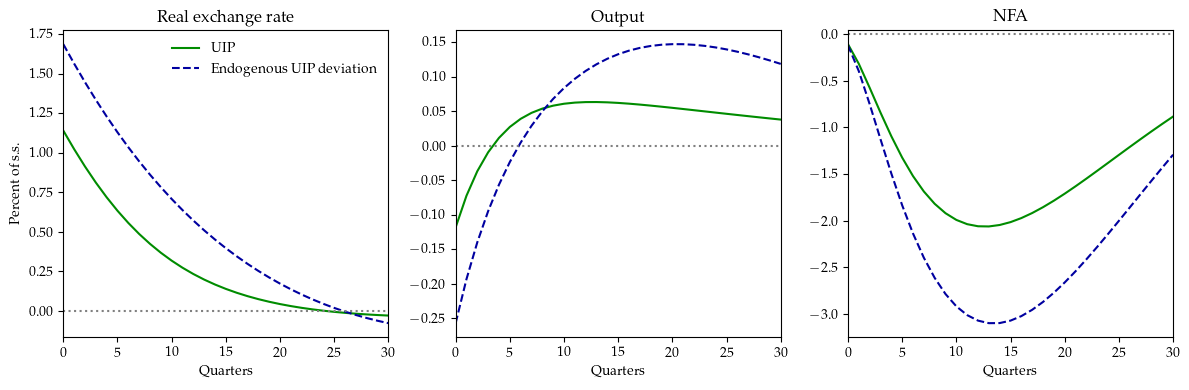

In [125]:
# Steady state
ss = {}
ss['1'] = calibrate_ss(calib = 'quant', calib_list = calib_list, eta = 4, gamma = 4, theta_share = calib_list['theta_share'], theta_w=0.938, theta_X = 0.66, theta_p=0.66, phi_i = 0.8, phi_pinext = 1.5, verbose=False)
ss['2'] = ss['1'].copy()
m_list = ['1','2']
T = 500

# Add phi
ss['1']['phi_rstar'] = 0
ss['2']['phi_rstar'] = 0.01
for m in m_list: ss[m]['rstar_exo'] = ss[m]['rstar']

# Compute model jacobian
G = {}
for m in m_list: 
    G[m] = mod_uip.solve_jacobian(ss[m], unknowns_uip, targets_uip, exogenous_uip, T=T)
    print('Walras = ', np.max(np.abs(G[m]['assets_clearing']['rstar_exo'][:50,:50])))

# Compute IRF
va = ['y','nfa','rstar','rstar_exo','Q']
dr, dQ = aux_fn.rshock(0.01,0.85,ss['1'],T,'rstar',Q0=1)
irf = {}
for m in m_list: 
    irf[m] = aux_fn.irf_make(G[m],dr,'rstar_exo',va,T)

# Plot
Tplot = 31
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.title(r'Real exchange rate')
plt.plot(100*irf['1']['Q'][:Tplot], color=greenslide, label='UIP')
plt.plot(100*irf['2']['Q'][:Tplot], color=blueslide, linestyle='--', label='Endogenous UIP deviation')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.legend(framealpha=0)
plt.ylabel('Percent of s.s.')
plt.xlabel('Quarters')
plt.subplot(1,3,2)
plt.title(r'Output')
plt.plot(100*irf['1']['y'][:Tplot], color=greenslide, label='Q')
plt.plot(100*irf['2']['y'][:Tplot], color=blueslide, linestyle='--', label='Q')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.xlabel('Quarters')
plt.subplot(1,3,3)
plt.title(r'NFA')
plt.plot(100*irf['1']['nfa'][:Tplot], color=greenslide, label='Q')
plt.plot(100*irf['2']['nfa'][:Tplot], color=blueslide, linestyle='--', label='Q')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.xlabel('Quarters')
plt.tight_layout()
plt.show();